# Training&Evaluation of a developed algorithm

In this python notebook you can try several possible architectures and train&evaluate them.

0. Utilities

In [1]:
import sys
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')
from tqdm.auto import tqdm
import pandas as pd

# Used memory analysis utility
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

# Print all allocated variables
def print_mem_usage():
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                             key= lambda x: x[1],
                             reverse=True)[:10]:
        print("Global {:>30}: {:>8}".format(name, sizeof_fmt(size)))    
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                             key= lambda x: x[1],
                             reverse=True)[:10]:
        print("Local {:>30}: {:>8}".format(name, sizeof_fmt(size)))

In [2]:
import torch

# Check CUDA is available
print(torch.cuda.is_available())

True


1. Create a `Summarizer`&`Classifier` class.

It has several options to set up: 
* with or without features (right now without features works better), 
* `BERT` or `roberta` as basis (no big difference), 

You can also choose `frozen_strategy`:
* `froze_all` in case you don't want to improve bert layers but only the summarization layer, 
* `unfroze_last4` -- modifies bert weights and still training not very slow, 
* `unfroze_all` -- the training is slow, the results may better though

In [18]:
import os
import torch.nn as nn
import torch
import numpy as np
from transformers import BertModel, RobertaModel
from collections import namedtuple
from transformers import BertTokenizer, RobertaTokenizer
from pysrc.review.train.preprocess import parse_sents, standardize, greedy_selection
from pathlib import Path

import pysrc.review.config as cfg
from pysrc.review.utils import get_ids_mask


SpecToken = namedtuple('SpecToken', ['tkn', 'idx'])
ConvertToken2Id = lambda tokenizer, tkn: tokenizer.convert_tokens_to_ids([tkn])[0]


class Summarizer(nn.Module):

    enc_output: torch.Tensor
    rouges_values: np.array = np.zeros(4)
    dec_ids_mask: torch.Tensor
    encdec_ids_mask: torch.Tensor

    def __init__(self, model_type, article_len, with_features=False, num_features=10):
        super(Summarizer, self).__init__()

        self.article_len = article_len

        if model_type == 'bert':
            self.backbone, self.tokenizer, BOS, EOS, PAD = self.initialize_bert()
        elif model_type == 'roberta':
            self.backbone, self.tokenizer, BOS, EOS, PAD = self.initialize_roberta()
        else:
            raise Exception(f"Wrong model_type argument: {model_type}")
            
        if with_features:
            self.features = nn.Sequential(nn.Linear(num_features, 100),
                                          nn.ReLU(),
                                          nn.Linear(100, 100),
                                          nn.ReLU(),
                                          nn.Linear(100, 50))
        else:
            self.features = None

        self.PAD = SpecToken(PAD, ConvertToken2Id(self.tokenizer, PAD))
        self.artBOS = SpecToken(BOS, ConvertToken2Id(self.tokenizer, BOS))
        self.artEOS = SpecToken(EOS, ConvertToken2Id(self.tokenizer, EOS))

        # add special tokens tokenizer
        self.tokenizer.add_special_tokens({'additional_special_tokens': ["<sum>", "</sent>", "</sum>"]})
        self.vocab_size = len(self.tokenizer)
        self.sumBOS = SpecToken("<sum>", ConvertToken2Id(self.tokenizer, "<sum>"))
        self.sumEOS = SpecToken("</sent>", ConvertToken2Id(self.tokenizer, "</sent>"))
        self.sumEOA = SpecToken("</sum>", ConvertToken2Id(self.tokenizer, "</sum>"))
        self.backbone.resize_token_embeddings(200 + self.vocab_size)

        # tokenizer
        self.tokenizer.PAD = self.PAD
        self.tokenizer.artBOS = self.artBOS
        self.tokenizer.artEOS = self.artEOS
        self.tokenizer.sumBOS = self.sumBOS
        self.tokenizer.sumEOS = self.sumEOS
        self.tokenizer.sumEOA = self.sumEOA
        self.vocab_size = len(self.tokenizer)

        # initialize backbone emb pulling
        def backbone_forward(input_ids, input_mask, input_segment, input_pos):
            return self.backbone(
                input_ids=input_ids,
                attention_mask=input_mask,
                token_type_ids=input_segment,
                position_ids=input_pos,
            )
        self.encoder = lambda *args: backbone_forward(*args)[0]

        # initialize decoder
        if not with_features:
            self.decoder = Classifier(cfg.d_hidden)
        else:
            self.decoder = Classifier(cfg.d_hidden + 50)

    def expand_posembs_ifneed(self):
        print(self.backbone.config.max_position_embeddings, self.article_len)
        if self.article_len > self.backbone.config.max_position_embeddings:
            print("OK")
            old_maxlen = self.backbone.config.max_position_embeddings
            old_w = self.backbone.embeddings.position_embeddings.weight
            logging.info(f"Backbone pos embeddings expanded from {old_maxlen} upto {self.article_len}")
            self.backbone.embeddings.position_embeddings = \
                nn.Embedding(self.article_len, self.backbone.config.hidden_size)
            self.backbone.embeddings.position_embeddings.weight[:old_maxlen].data.copy_(old_w)
            self.backbone.config.max_position_embeddings = self.article_len
        print(self.backbone.config.max_position_embeddings)

    @staticmethod
    def initialize_bert():
        backbone = BertModel.from_pretrained(
            "bert-base-uncased", output_hidden_states=False
        )
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

        BOS = "[CLS]"
        EOS = "[SEP]"
        PAD = "[PAD]"
        return backbone, tokenizer, BOS, EOS, PAD

    @staticmethod
    def initialize_roberta():
        backbone = RobertaModel.from_pretrained(
            'roberta-base', output_hidden_states=False
        )
        # initialize token type emb, by default roberta doesn't have it
        backbone.config.type_vocab_size = 2
        backbone.embeddings.token_type_embeddings = nn.Embedding(2, backbone.config.hidden_size)
        backbone.embeddings.token_type_embeddings.weight.data.normal_(
            mean=0.0, std=backbone.config.initializer_range
        )
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)
        BOS = "<s>"
        EOS = "</s>"
        PAD = "<pad>"
        return backbone, tokenizer, BOS, EOS, PAD

    def save(self, save_filename):
        """ Save model in filename

        :param save_filename: str
        """
        if not self.features:
            state = {
                'encoder_dict': self.backbone.state_dict(),
                'decoder_dict': self.decoder.state_dict(),
            }
        else:
            state = {
                'encoder_dict': self.backbone.state_dict(),
                'decoder_dict': self.decoder.state_dict(),
                'features_dict': self.features.state_dict(),
            }
        models_folder = os.path.abspath(cfg.weights_path)
        if not os.path.exists(models_folder):
            os.mkdirs(models_folder)
        torch.save(state, f"{models_folder}/{save_filename}.pth")

    def load(self, load_filename):
        path = f"{os.path.abspath(cfg.weights_path)}/{load_filename}.pth"
        state = torch.load(path, map_location=lambda storage, location: storage)
        self.backbone.load_state_dict(state['encoder_dict'])
        self.decoder.load_state_dict(state['decoder_dict'])
        if self.features:
            self.features.load_state_dict(state['features_dict'])
        

    def froze_backbone(self, froze_strategy):

        assert froze_strategy in ['froze_all', 'unfroze_last4', 'unfroze_all'],\
            f"incorrect froze_strategy argument: {froze_strategy}"

        if froze_strategy == 'froze_all':
            for name, param in self.backbone.named_parameters():
                param.requires_grad_(False)

        elif froze_strategy == 'unfroze_last4':
            for name, param in self.backbone.named_parameters():
                param.requires_grad_(True if (
                    'encoder.layer.11' in name or
                    'encoder.layer.10' in name or
                    'encoder.layer.9' in name or
                    'encoder.layer.8' in name
                ) else False)

        elif froze_strategy == 'unfroze_all':
            for param in self.backbone.parameters():
                param.requires_grad_(True)

    def unfroze_head(self):

        for name, param in self.decoder.named_parameters():
            param.requires_grad_(True)

    @property
    def rouge_1(self):
        return self.rouges_values[0]

    @property
    def rouge_2(self):
        return self.rouges_values[1]

    @property
    def rouge_l(self):
        return self.rouges_values[2]

    @property
    def rouge_mean(self):
        return self.rouges_values[3]

    def forward(self, input_ids, input_mask, input_segment, input_features=None):
        """ Train for 1st stage of model

        :param input_ids: torch.Size([batch_size, article_len])
        :param input_mask: torch.Size([batch_size, article_len])
        :param input_segment: torch.Size([batch_size, article_len])
        :return:
            logprobs | torch.Size([batch_size, summary_len, vocab_size])
        """
        
        cls_mask = (input_ids == self.artBOS.idx)

        # position ids | torch.Size([batch_size, article_len])
        pos_ids = torch\
            .arange(0, self.article_len, dtype=torch.long, device=input_ids.device)\
            .unsqueeze(0)\
            .repeat(len(input_ids), 1)
        # extract bert embeddings | torch.Size([batch_size, article_len, d_bert])
        enc_output = self.encoder(input_ids, input_mask, input_segment, pos_ids)
        
        if self.features:
            temp_features = self.features(input_features)
            draft_logprobs = self.decoder(torch.cat([enc_output[cls_mask], temp_features], dim=-1))
        else:
            draft_logprobs = self.decoder(enc_output[cls_mask])

        return draft_logprobs

    def evaluate(self, input_ids, input_mask, input_segment, input_features=None):
        """ Eval for 1st stage of model

        :param input_ids: torch.Size([batch_size, article_len])
        :param input_mask: torch.Size([batch_size, article_len])
        :param input_segment: torch.Size([batch_size, article_len])
        :return:
            draft_ids | torch.Size([batch_size, summary_len])
        """

        cls_mask = (input_ids == self.artBOS.idx)

        # position ids | torch.Size([batch_size, article_len])
        pos_ids = torch\
            .arange(0, self.article_len, dtype=torch.long, device=input_ids.device)\
            .unsqueeze(0)\
            .repeat(len(input_ids), 1)
        # extract bert embeddings | torch.Size([batch_size, article_len, d_bert])
        enc_output = self.encoder(input_ids, input_mask, input_segment, pos_ids)

        ans = []
        for eo, cm in zip(enc_output, cls_mask):
            if self.features:
                scores = self.decoder.evaluate(torch.cat([eo[cm], self.features(input_features)], dim=-1))
            else:
                scores = self.decoder.evaluate(eo[cm])
            ans.append(scores)
        return ans


class Classifier(nn.Module):
    def __init__(self, hidden_size):
        super(Classifier, self).__init__()
        self.linear1 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x).squeeze(-1)
        scores = self.sigmoid(x)
        return scores

    def evaluate(self, x):
        x = self.linear1(x).squeeze(-1)
        scores = self.sigmoid(x)
        return scores

2. `train_fun` -- training function for model without features. \
`train_fun_ft` -- training function for model with features.

In [4]:
from torch.optim.optimizer import Optimizer
from tqdm import tqdm
import math
from pysrc.review.utils import get_enc_lr, get_dec_lr

def backward_step(loss: torch.Tensor, optimizer: Optimizer, model: nn.Module, clip: float, amp_enabled: int):
    loss.backward()
    total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    return total_norm

def train_fun(model, dataloader, optimizer, scheduler, criter, device, rank, writer, distributed):

    # draft, refine
    model.train()
    model_ref = model.module if distributed else model

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, disable=rank != 0)
    for idx_batch, batch in pbar:
        
        input_ids, input_mask, input_segment, target_scores = \
            [(x.to(device) if isinstance(x, torch.Tensor) else x) for x in batch]
        target_scores = torch.cat(target_scores).to(device)

        # forward pass
        draft_probs = model(
            input_ids, input_mask, input_segment,
        )

        try:
        # loss
            loss = criter(
                draft_probs,
                target_scores,
            )
        except Exception:
            print(idx_batch, draft_probs.shape, target_scores.shape, input_segment)
            return

        # backward
        grad_norm = backward_step(loss, optimizer, model, optimizer.clip_value, amp_enabled=cfg.amp_enabled)
        grad_norm = 0 if (math.isinf(grad_norm) or math.isnan(grad_norm)) else grad_norm

        # record a loss value
        # loss_val += loss.item() * len(input_ids)
        pbar.set_description(f"loss:{loss.item():.2f}")
        writer.add_scalar(f"Train/loss", loss.item(), writer.train_step)
        writer.add_scalar("Train/grad_norm", grad_norm, writer.train_step)
        writer.add_scalar("Train/lr_enc", get_enc_lr(optimizer), writer.train_step)
        writer.add_scalar("Train/lr_dec", get_dec_lr(optimizer), writer.train_step)
        writer.train_step += 1

        # make a gradient step
        if (idx_batch + 1) % optimizer.accumulation_interval == 0 or (idx_batch + 1) == len(dataloader):
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()

    # overall loss per epoch
    # if distributed:
    #     loss_val = distribute(loss_val, device)
    # logging.info(f"mean loss: {loss_val / len(dataloader.dataset):.4f}", is_print=rank == 0)

    # save model, just in case
    if rank == 0:
        model_ref.save('temp')

    return model, optimizer, scheduler, writer

def train_fun_ft(model, dataloader, optimizer, scheduler, criter, device, rank, writer, distributed):

    # draft, refine
    model.train()
    model_ref = model.module if distributed else model

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, disable=rank != 0)
    for idx_batch, batch in pbar:
        
        input_ids, input_mask, input_segment, target_scores, input_features = \
            [(x.to(device) if isinstance(x, torch.Tensor) else x) for x in batch]
        target_scores = torch.cat(target_scores).to(device)
        input_features = torch.cat(input_features).to(device)
        # forward pass
        draft_probs = model(
            input_ids, input_mask, input_segment, input_features,
        )

        try:
        # loss
            loss = criter(
                draft_probs,
                target_scores,
            )
        except Exception:
            print(idx_batch, draft_probs.shape, target_scores.shape, input_segment)
            return

        # backward
        grad_norm = backward_step(loss, optimizer, model, optimizer.clip_value, amp_enabled=cfg.amp_enabled)
        grad_norm = 0 if (math.isinf(grad_norm) or math.isnan(grad_norm)) else grad_norm

        # record a loss value
        # loss_val += loss.item() * len(input_ids)
        pbar.set_description(f"loss:{loss.item():.2f}")
        writer.add_scalar(f"Train/loss", loss.item(), writer.train_step)
        writer.add_scalar("Train/grad_norm", grad_norm, writer.train_step)
        writer.add_scalar("Train/lr_enc", get_enc_lr(optimizer), writer.train_step)
        writer.add_scalar("Train/lr_dec", get_dec_lr(optimizer), writer.train_step)
        writer.train_step += 1

        # make a gradient step
        if (idx_batch + 1) % optimizer.accumulation_interval == 0 or (idx_batch + 1) == len(dataloader):
            optimizer.step()
            optimizer.zero_grad()
        scheduler.step()

    # overall loss per epoch
    # if distributed:
    #     loss_val = distribute(loss_val, device)
    # logging.info(f"mean loss: {loss_val / len(dataloader.dataset):.4f}", is_print=rank == 0)

    # save model, just in case
    if rank == 0:
        model_ref.save('temp')

    return model, optimizer, scheduler, writer

3. `load_data` loads all the needed datafiles for building train dataset.\
The several next steps are only should be done if no train/test/val datasets are saved.

In [5]:
def load_data(root2data, ft):
    logging.info('Loading citations_df')
    citations_df = pd.read_csv(root2data / "citations.csv", sep='\t')
    logging.info(sizeof_fmt(sys.getsizeof(citations_df)))

    logging.info('Loading sentences_df')
    sentences_df = pd.read_csv(root2data / "sentences.csv", sep='\t')
    logging.info(sizeof_fmt(sys.getsizeof(sentences_df)))

    logging.info('Loading ref_sents_df')
    ref_sents_df = pd.read_csv(root2data / "ref_sents.csv", sep='\t')
    logging.info(sizeof_fmt(sys.getsizeof(ref_sents_df)))

    logging.info('Loading review_files_df')
    review_files_df = pd.read_csv(root2data / "review_files.csv", sep='\t')
    logging.info(sizeof_fmt(sys.getsizeof(review_files_df)))

    logging.info('Loading reverse_ref_df')
    reverse_ref_df = pd.read_csv(root2data / "reverse_ref.csv", sep='\t')
    logging.info(sizeof_fmt(sys.getsizeof(reverse_ref_df)))
    if not ft:
        return citations_df, sentences_df, ref_sents_df, review_files_df, reverse_ref_df

    logging.info('Loading abstracts_df')
    abstracts_df = pd.read_csv(root2data / "abstracts.csv", sep='\t')
    logging.info(sizeof_fmt(sys.getsizeof(abstracts_df)))
    
    logging.info('Loading filelist_df')
    filelist_df = pd.read_csv(root2data / "filelist.csv", sep=',')
    logging.info(sizeof_fmt(sys.getsizeof(filelist_df)))
        
    logging.info('Loading figures_df')
    figures_df = pd.read_csv(root2data / "figures.csv", sep='\t')
    logging.info(sizeof_fmt(sys.getsizeof(figures_df)))
        
    logging.info('Loading tables_df')
    tables_df = pd.read_csv(root2data / "tables.csv", sep='\t')
    logging.info(sizeof_fmt(sys.getsizeof(tables_df)))
    return citations_df, sentences_df, ref_sents_df, review_files_df, reverse_ref_df, \
        abstracts_df, filelist_df, figures_df, tables_df    

4. `get_rouge` function will be needed anyway. You can uncomment `rouge-l`, if you want. 

In [6]:
from rouge import Rouge

ROUGE_METER = Rouge()
TOKENIZER = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def get_rouge(sent1, sent2):
    sent_1 = TOKENIZER.tokenize(sent1)
    #print(sent_1)
    sent_1 = " ".join(list(filter(lambda x: x.isalpha() or x in '.!,?', sent_1)))
    #print(sent_1)
    sent_2 = TOKENIZER.tokenize(sent2)
    sent_2 = " ".join(list(filter(lambda x: x.isalpha() or x in '.!,?', sent_2)))
    rouges = ROUGE_METER.get_scores(sent_1, sent_2)[0]
    rouges = [rouges[f'rouge-{x}']["f"] for x in ('1', '2')] # , 'l')]
    return np.mean(rouges) * 100

In [7]:
get_rouge("I am scout. True!", "No you are not a scout.")

9.090908842975212

5. Several functions needed to build the datasets. If the datasets alredy exist, do not have to run this cell.

In [8]:
from unidecode import unidecode
from nltk.tokenize import sent_tokenize
import re

REPLACE_SYMBOLS = {
    '—': '-',
    '–': '-',
    '―': '-',
    '…': '...',
    '´´': "´",
    '´´´': "´´",
    "''": "'",
    "'''": "'",
    "``": "`",
    "```": "`",
    ":": " : ",
}

def parse_sents(data):
    sents = sum([sent_tokenize(text) for text in data], [])
    sents = [x for x in text if len(x) > 3]
    return sents

def sent_standardize(sent):
    sent = unidecode(sent)
    sent = re.sub(r"\[(xref_\w*_\w\d*]*)(, xref_\w*_\w\d*)*\]", " ", sent)  # delete [xref,...]
    sent = re.sub(r"\( (xref_\w*_\w\d*)(; xref_\w*_\w\d*)* \)", " ", sent)  # delete (xref; ...)
    sent = re.sub(r"\[xref_\w*_\w\d*\]", " ", sent)  # delete [xref]
    sent = re.sub(r"xref_\w*_\w\d*", " ", sent)  # delete [[xref]]
    for k, v in REPLACE_SYMBOLS.items():
        sent = sent.replace(k, v)
    return sent.strip()


def standardize(text):
    return [x for x in (sent_standardize(sent) for sent in text) if len(x) > 3]



def preprocess_paper(paper_id, sentences_df, ref_sents_df):
    paper = sentences_df[sentences_df['pmid'] == paper_id]['sentence']
    paper = standardize(paper)
    
    ref_sents = ref_sents_df[ref_sents_df['ref_pmid'] == paper_id]['sentence']
    ref_sents = standardize(ref_sents)
    
    if len(paper) < 50:
        return None
            
    if len(paper) > 100:
        paper = list(paper[:50]) + list(paper[-50:])
    
    preprocessed_score = [sum(get_rouge(sent, ref_sent) for ref_sent in ref_sents) / len(ref_sents)
                          for sent in paper]
    return paper, preprocessed_score

def preprocess_paper_with_features(paper_id, sentences_df, ref_sents_df, abstracts_df, \
                                   figures_df, reverse_ref_df, tables_df):
    preprocessed_score = []
    features = []
    
    paper = sentences_df[sentences_df['pmid'] == paper_id]['sentence']
    paper = standardize(paper)
    
    sent_ids = sentences_df[sentences_df['pmid'] == paper_id]['sent_id']
    
    sent_types = sentences_df[sentences_df['pmid'] == paper_id]['type']
    
    ref_sents = ref_sents_df[ref_sents_df['ref_pmid'] == paper_id]['sentence']
    ref_sents = standardize(ref_sents)

    
    fig_captions = figures_df[figures_df['pmid'] == paper_id]['caption']
    fig_captions = standardize(fig_captions)
    
    tab_captions = tables_df[tables_df['pmid'] == paper_id]['caption']
    tab_captions = standardize(tab_captions)
    
    abstract = abstracts_df[abstracts_df['pmid'] == paper_id]['abstract']
    if len(abstract) != 0:
        abstract = standardize(abstract)
    
    tmp_df = reverse_ref_df[reverse_ref_df['pmid'] == paper_id]
    
    if len(paper) < 50:
        return None
            
    if len(paper) > 100:
        paper = list(paper[:50]) + list(paper[-50:])
        sent_ids = list(sent_ids[:50]) + list(sent_ids[-50:])
        sent_types = list(sent_types[:50]) + list(sent_types[-50:])
        
        
    def mean_rouge(sent, text):
        try:
            return sum(get_rouge(sent, ref_sent) for ref_sent in text) / len(text)
        except Exception as e:
            logging.error(f'Exception at mean_rouge {e}')
            return None
    
    def min_rouge(sent, text):
        try:
            score = 100000000
            for ref_sent in text:
                score = min(get_rouge(sent, ref_sent), score)
            if score == 100000000:
                return None
            return score
        except Exception as e:
            logging.error(f'Exception at min_rouge {e}')
            return None
    
    def max_rouge(sent, text):
        try:
            score = -100000
            for ref_sent in text:
                score = max(get_rouge(sent, ref_sent), score)
            if score == -100000:
                return None
            return score
        except Exception as e:
            logging.error(f'Exception at max_rouge {e}')
            return None
    
    for i, sent in enumerate(paper):
        score = mean_rouge(sent, ref_sents)
        if score is None:
            return None
        
        try:
            abst_diff = get_rouge(sent, abstract[0])
        except Exception as e:
            logging.error(f'Exception at preprocess_paper_with_features {e}')
            abst_diff = None
        num_refs = len(tmp_df[(tmp_df['sent_type'] == sent_types[i]) & (tmp_df['sent_id'] == sent_ids[i])])
        preprocessed_score.append(score)
        features.append((sent_ids[i], int(sent_types[i] == "general"), abst_diff, num_refs,\
                        mean_rouge(sent, fig_captions), mean_rouge(sent, tab_captions),\
                        min_rouge(sent, fig_captions), min_rouge(sent, tab_captions), \
                        max_rouge(sent, fig_captions), max_rouge(sent, tab_captions)))
    return paper, preprocessed_score, features

6. Download data to make datasets from it. If datasets with features are needed, the commented code here should be uncommented.

In [20]:
root2data = Path("~/dataset_with_refs")
logging.info(f'Loading references dataset from root2data {root2data}')

citations_df, sentences_df, ref_sents_df, review_files_df, reverse_ref_df = load_data(root2data, ft=False)

# Uncomment to load additional features
# citations_df, sentences_df, ref_sents_df, review_files_df, reverse_ref_df, \
#     abstracts_df, filelist_df, figures_df, tables_df = load_data(root2data)

logging.info('Done loading references dataset')

2020-12-29 14:46:30,060 INFO: Loading references dataset from root2data ~/dataset_with_refs
2020-12-29 14:46:30,061 INFO: Loading citations_df
2020-12-29 14:47:20,409 INFO: 2.5 GiB
2020-12-29 14:47:20,409 INFO: Loading sentences_df
2020-12-29 14:54:35,839 INFO: 34.4 GiB
2020-12-29 14:54:35,839 INFO: Loading ref_sents_df
2020-12-29 14:54:39,110 INFO: 359.6 MiB
2020-12-29 14:54:39,111 INFO: Loading review_files_df
2020-12-29 14:54:39,127 INFO: 653.3 KiB
2020-12-29 14:54:39,128 INFO: Loading reverse_ref_df
2020-12-29 14:56:36,866 INFO: 5.9 GiB
2020-12-29 14:56:36,867 INFO: Done loading references dataset


7. In case datasets are not yet created and `ref_sents_df` is also not yet created, let's create `ref_sents_df`.\
For each paper pmid there is a list of sentences from review papers in which the paper with this `pmid` is cited.

In [19]:
REF_SENTS_DF_PATH = os.path.expanduser("~/dataset_with_refs/ref_sents.csv")
if os.path.exists(REF_SENTS_DF_PATH):
    ref_sents_df = pd.read_csv(REF_SENTS_DF_PATH, sep='\t')
else:
    logging.info('Creating reference sentences dataset')
    ref_sents_df = pd.merge(citations_df, reverse_ref_df, left_on = ['pmid', 'ref_id'], right_on = ['pmid', 'ref_id'])
    ref_sents_df = pd.merge(ref_sents_df, sentences_df, left_on = ['pmid', 'sent_type', 'sent_id'], right_on = ['pmid', 'type', 'sent_id'])
    ref_sents_df = ref_sents_df[ref_sents_df['pmid'].isin(review_files_df['pmid'].values)]    
    ref_sents_df = ref_sents_df.drop_duplicates()
    logging.info(f'Len of unique ref_sents {len(set(ref_sents_df["ref_pmid"]))}')
    ref_sents_df = ref_sents_df[['pmid', 'ref_id', 'pub_type', 'ref_pmid', 'sent_type', 'sent_id', 'sentence']]
    ref_sents_df.to_csv(REF_SENTS_DF_PATH, sep='\t', index=False)

In [17]:
display(ref_sents_df.head())

,pmid,ref_id,pub_type,ref_pmid,sent_type,sent_id,sentence
0,11978898,R2,journal,9657795,general,0,Deliberate self-poisoning has reached epidemic...
1,11978898,R12,journal,8783813,general,8,In vitro experiments have shown that oximes ar...
2,11978898,R13,journal,8481105,general,8,In vitro experiments have shown that oximes ar...
3,11978898,R15,journal,9292288,general,8,In vitro experiments have shown that oximes ar...
4,11978898,R12,journal,8783813,general,10,"It has now become clear, however, that the deg..."


8. To create a dataset with features use `preprocess_paper_with_features`. Otherwise, use `preprocess_paper`. 

In [21]:
def process_reference_sentences_dataset(sentences_df, ref_sents_df):
    res = {}
    inter = set(sentences_df['pmid'].values) & set(ref_sents_df['ref_pmid'].values)
    linter = len(inter)
    for i, pmid in enumerate(inter):
        try:
            # For dataset with additional features uncomment this
    #         temp = preprocess_paper_with_features(pmid, sentences_df, ref_sents_df, abstracts_df,
    #                                               figures_df, reverse_ref_df, tables_df)
            temp = preprocess_paper(pmid, sentences_df, ref_sents_df)
        except Exception as e:
            logging.warning(f'Error during processing {pmid} {e}')
            continue
        if temp is None:
            logging.warning(f'temp is None for {pmid}')
            continue
        res[pmid] = temp
        print(f"\r{i}/{linter} {pmid} {np.mean(res[pmid][1])}", end="")

    logging.info(f'Successfully preprocessed {len(res)} of {len(inter)} papers')

    logging.info(f'Creating train dataset')
    feature_names = ['sent_id', 'sent_type', 'r_abs', 'num_refs', \
                 'mean_r_fig', 'mean_r_tab',\
                 'min_r_fig', 'min_r_tab',\
                 'max_r_fig', 'max_r_tab']
    train_dic = {'pmid':[], 'sentence':[], 'score':[],\
                'sent_id':[], 'sent_type':[], 'r_abs':[], 'num_refs':[], \
                     'mean_r_fig':[], 'mean_r_tab':[],\
                     'min_r_fig':[], 'min_r_tab':[],\
                     'max_r_fig':[], 'max_r_tab':[]}

    for pmid, stat in tqdm(res.items()):
        if len(stat) == 2:
            for sent, score in zip(*stat):
                train_dic['pmid'].append(pmid)
                train_dic['sentence'].append(sent)
                train_dic['score'].append(score)    
        else:
            for sent, score, features in zip(*stat):
                train_dic['pmid'].append(pmid)
                train_dic['sentence'].append(sent)
                train_dic['score'].append(score)
                for name, val in zip(feature_names, features):
                    train_dic[name].append(val)

    train_df = pd.DataFrame({k:v for k,v in train_dic.items() if v})
    logging.info(f'Full train dataset {len(train_df)}')
    return train_df

In [ ]:
TRAIN_DATASET_PATH = os.path.expanduser('˜/dataset.csv')
if os.path.exists(TRAIN_DATASET_PATH):
    train_df = pd.read_csv(TRAIN_DATASET_PATH)
else:
    train_df = process_reference_sentences_dataset(sentences_df, ref_sents_df)
    train_df.to_csv(TRAIN_DATASET_PATH, index=False)

4/25033 22020140 10.386586244216467

2020-12-29 15:26:55,908 WARNING: temp is None for 25559091


33/25033 19398967 12.477530710148207

2020-12-29 15:27:19,008 WARNING: temp is None for 23724363


64/25033 23462319 10.890494606887696

2020-12-29 15:27:32,398 WARNING: temp is None for 19136953


107/25033 18481837 11.690525257056711

2020-12-29 15:28:03,308 WARNING: temp is None for 24511163
2020-12-29 15:28:03,378 WARNING: temp is None for 20579007


200/25033 22021288 4.5148969392325625

2020-12-29 15:28:56,984 WARNING: temp is None for 22021295


520/25033 19139294 6.3608503080275159

2020-12-29 15:32:03,328 WARNING: temp is None for 22416097


527/25033 22940426 10.346726186676474

2020-12-29 15:32:05,499 WARNING: temp is None for 19139352


569/25033 26479555 8.3036033815426794

2020-12-29 15:32:34,901 WARNING: temp is None for 23727045


617/25033 20712640 16.103775857593035

2020-12-29 15:33:06,602 WARNING: temp is None for 20581575


678/25033 20581870 14.183523941842186

2020-12-29 15:33:44,183 WARNING: temp is None for 20581873


725/25033 23465745 9.1609014388697302

2020-12-29 15:34:13,670 WARNING: temp is None for 25693976


741/25033 22548305 10.249741728475708

2020-12-29 15:34:24,146 WARNING: temp is None for 27397970


770/25033 22810586 9.8445357536004226

2020-12-29 15:34:39,652 WARNING: temp is None for 19927006


822/25033 22810892 9.8257860444539424

2020-12-29 15:35:20,095 WARNING: temp is None for 19271966


836/25033 21631316 6.5958893882284637

2020-12-29 15:35:28,745 WARNING: temp is None for 21631319


884/25033 20451870 9.5669757407861556

2020-12-29 15:36:06,704 WARNING: Error during processing 20451871 Hypothesis is empty.


915/25033 27398874 7.7280004635808925

2020-12-29 15:36:33,034 WARNING: temp is None for 23597792


933/25033 22287160 4.8877478393310161

2020-12-29 15:36:47,049 WARNING: temp is None for 24515395


984/25033 21238868 8.4664472678049242

2020-12-29 15:37:16,007 WARNING: temp is None for 21894242


1019/25033 25040123 3.8739336641631117

2020-12-29 15:37:37,857 WARNING: temp is None for 27923719


1042/25033 22943101 7.7766416471623065

2020-12-29 15:37:52,480 WARNING: temp is None for 20190592


1076/25033 20190787 9.7977536944625711

2020-12-29 15:38:07,776 WARNING: temp is None for 26089051


1081/25033 22156901 10.094599138059282

2020-12-29 15:38:09,299 WARNING: temp is None for 21370473


1225/25033 20977941 11.308629734705251

2020-12-29 15:39:31,656 WARNING: temp is None for 26220833


1231/25033 24123709 11.013073066328564

2020-12-29 15:39:34,027 WARNING: Error during processing 19405132 Hypothesis is empty.


1267/25033 23075288 8.4307309473965815

2020-12-29 15:40:06,382 WARNING: temp is None for 24517083


1279/25033 20978189 10.069876462495193

2020-12-29 15:40:13,321 WARNING: Error during processing 21502479 Hypothesis is empty.


1401/25033 22420597 9.5287241194523585

2020-12-29 15:41:20,004 WARNING: temp is None for 20847735


1537/25033 23863078 9.3229010444746799

2020-12-29 15:42:21,482 WARNING: temp is None for 22945592


1558/25033 22421367 11.473294512143267

2020-12-29 15:42:32,511 WARNING: temp is None for 21241731


1631/25033 22028490 11.888225170711866

2020-12-29 15:43:21,493 WARNING: temp is None for 21111000


1660/25033 22552952 13.720187380802958

2020-12-29 15:43:42,902 WARNING: temp is None for 19538306


1674/25033 24388019 8.7887572048084273

2020-12-29 15:43:49,080 WARNING: temp is None for 24125888


1772/25033 22684657 10.668918586999258

2020-12-29 15:45:01,011 WARNING: temp is None for 21373949


1922/25033 19932916 9.2819634420695045

2020-12-29 15:46:25,784 WARNING: temp is None for 19015434


1934/25033 24651583 12.007220141773715

2020-12-29 15:46:32,066 WARNING: temp is None for 19670862


2019/25033 19802380 9.7479233326555377

2020-12-29 15:47:28,078 WARNING: temp is None for 20064545


2135/25033 23735037 12.150749454871809

2020-12-29 15:48:48,408 WARNING: Error during processing 25438981 Hypothesis is empty.


2188/25033 20065205 8.9952714246087563

2020-12-29 15:49:12,701 WARNING: temp is None for 20065210


2254/25033 23080227 13.874572184869535

2020-12-29 15:49:45,278 WARNING: temp is None for 21507371


2297/25033 26095119 12.611595219078918

2020-12-29 15:50:19,233 WARNING: temp is None for 21376537


2357/25033 21245734 8.2975885220044878

2020-12-29 15:50:46,172 WARNING: temp is None for 21114675
2020-12-29 15:50:46,242 WARNING: temp is None for 24129332


2386/25033 20590543 9.4279928170148737

2020-12-29 15:51:01,083 WARNING: temp is None for 23343059


2453/25033 21508443 10.427633370571534

2020-12-29 15:51:53,639 WARNING: temp is None for 21115248


2479/25033 23474642 9.2740010108892313

2020-12-29 15:52:11,937 WARNING: Error during processing 23998947 Hypothesis is empty.


2486/25033 19018250 6.8178625561270596

2020-12-29 15:52:16,714 WARNING: temp is None for 19673616


2489/25033 21901841 13.243714983344221

2020-12-29 15:52:17,522 WARNING: temp is None for 27275812


2534/25033 24916793 9.1018793843739259

2020-12-29 15:52:52,280 WARNING: temp is None for 22688574


2570/25033 19149822 7.7891742346361305

2020-12-29 15:53:11,369 WARNING: temp is None for 20460555


2692/25033 23606921 9.7359206177619295

2020-12-29 15:54:16,704 WARNING: temp is None for 21247634
2020-12-29 15:54:16,777 WARNING: temp is None for 20461219


2708/25033 22951636 7.5366253382932959

2020-12-29 15:54:28,780 WARNING: temp is None for 21771991
2020-12-29 15:54:28,848 WARNING: temp is None for 21771992


2747/25033 21378990 11.237320659869845

2020-12-29 15:54:45,516 WARNING: temp is None for 25442229


2753/25033 25835462 13.146076887085992

2020-12-29 15:54:48,899 WARNING: temp is None for 28194770


2790/25033 22689914 13.483864055960707

2020-12-29 15:55:07,541 WARNING: temp is None for 25049215


2817/25033 25180436 9.3006355763177565

2020-12-29 15:55:27,765 WARNING: temp is None for 27015458


2848/25033 23345604 9.7448105185570614

2020-12-29 15:55:43,918 WARNING: temp is None for 21903818


2855/25033 18627038 9.7413345405838374

2020-12-29 15:55:47,905 WARNING: temp is None for 19151365


2867/25033 22297150 8.7097536820442583

2020-12-29 15:55:53,424 WARNING: temp is None for 18758235


2884/25033 24656585 9.4827459875367181

2020-12-29 15:56:03,487 WARNING: temp is None for 26098405


2901/25033 26491707 5.4998693742119955

2020-12-29 15:56:18,305 WARNING: temp is None for 22035261


2956/25033 20069447 9.2236534715558885

2020-12-29 15:56:52,780 WARNING: temp is None for 22166604


2957/25033 20200519 14.03427362303713

2020-12-29 15:56:53,096 WARNING: temp is None for 20855907


2966/25033 22428793 10.501453159907362

2020-12-29 15:56:58,841 WARNING: temp is None for 23477384


3087/25033 23084843 8.2426827384722862

2020-12-29 15:58:14,467 WARNING: temp is None for 22560555


3098/25033 19152718 8.1924698631480603

2020-12-29 15:58:18,625 WARNING: temp is None for 18628439


3129/25033 21381083 10.964381475760488

2020-12-29 15:58:35,127 WARNING: temp is None for 20332526


3134/25033 21381106 13.239117545473528

2020-12-29 15:58:36,947 WARNING: temp is None for 22560758


3231/25033 20070865 8.5856205692258677

2020-12-29 15:59:45,925 WARNING: temp is None for 22823394


3268/25033 21119682 13.160209381036665

2020-12-29 16:00:13,494 WARNING: Error during processing 19022533 Hypothesis is empty.


3282/25033 23872239 8.6658872480258889

2020-12-29 16:00:21,348 WARNING: temp is None for 19022584


3288/25033 19153673 11.638024641087386

2020-12-29 16:00:24,778 WARNING: temp is None for 19284758


3310/25033 19022700 6.7142923096954741

2020-12-29 16:00:39,718 WARNING: temp is None for 27673455


3327/25033 20595660 8.6921706920638427

2020-12-29 16:00:52,728 WARNING: temp is None for 25314254


3380/25033 24528150 4.8789977701576055

2020-12-29 16:01:20,505 WARNING: temp is None for 23348505


3452/25033 22824630 7.1673378594619915

2020-12-29 16:02:00,800 WARNING: temp is None for 21907134


3489/25033 27150231 10.254157992915248

2020-12-29 16:02:21,722 WARNING: temp is None for 20727716


3520/25033 21514250 9.2077263803411966

2020-12-29 16:02:56,147 WARNING: Error during processing 22562829 Hypothesis is empty.


3534/25033 23349315 13.714799262366055

2020-12-29 16:03:03,009 WARNING: temp is None for 25053258


3546/25033 21383266 6.8937027146656895

2020-12-29 16:03:13,373 WARNING: temp is None for 26888297


3554/25033 20203636 12.296337163960823

2020-12-29 16:03:19,443 WARNING: temp is None for 23087235


3564/25033 25053346 5.1638342489276974

2020-12-29 16:03:29,254 WARNING: temp is None for 20203693


3611/25033 23742827 8.6458368762618647

2020-12-29 16:04:00,432 WARNING: temp is None for 22956404


3641/25033 25446896 11.195110698181939

2020-12-29 16:04:19,152 WARNING: temp is None for 19286518


3648/25033 21252632 5.9452849512049689

2020-12-29 16:04:22,270 WARNING: temp is None for 23218713


3662/25033 23218797 8.0885241012376499

2020-12-29 16:04:28,672 WARNING: temp is None for 22301310


3680/25033 21908183 11.034345716488968

2020-12-29 16:04:41,461 WARNING: temp is None for 25840376


3780/25033 20204773 7.2011260179835255

2020-12-29 16:05:41,589 WARNING: temp is None for 26103023


3849/25033 19680823 13.016984304249114

2020-12-29 16:06:28,206 WARNING: temp is None for 24661567


3904/25033 18632551 10.602730736726839

2020-12-29 16:06:58,780 WARNING: temp is None for 20467581


3912/25033 21516199 8.707205450464633

2020-12-29 16:07:01,311 WARNING: temp is None for 21122996


4048/25033 25580040 8.2868720850962134

2020-12-29 16:08:25,879 WARNING: temp is None for 19681807


4090/25033 22958863 9.5375395829217684

2020-12-29 16:08:49,837 WARNING: temp is None for 23483171


4172/25033 24401044 10.562108346787959

2020-12-29 16:09:36,184 WARNING: temp is None for 24401056


4179/25033 22041788 11.129132608269408

2020-12-29 16:09:39,218 WARNING: temp is None for 19420362


4233/25033 22697443 8.6194693836249012

2020-12-29 16:10:05,348 WARNING: Error during processing 21255654 Hypothesis is empty.


4456/25033 21518942 7.7799836271429515

2020-12-29 16:12:27,602 WARNING: temp is None for 24664676


4513/25033 19815286 8.1046816624976539

2020-12-29 16:13:00,861 WARNING: temp is None for 20732793


4534/25033 19028939 4.8042673723861982

2020-12-29 16:13:21,842 WARNING: temp is None for 19028956


4588/25033 22306005 10.261987683756983

2020-12-29 16:13:49,188 WARNING: temp is None for 22306015


4602/25033 27417877 7.8832382036708289

2020-12-29 16:13:59,061 WARNING: Error during processing 19029279 Hypothesis is empty.


4652/25033 21388857 7.2639138616064968

2020-12-29 16:14:28,951 WARNING: temp is None for 20733502


4698/25033 28073783 6.7867631779426378

2020-12-29 16:15:00,755 WARNING: temp is None for 15753023


4701/25033 21782353 9.617233664456618

2020-12-29 16:15:03,107 WARNING: temp is None for 22306650


4704/25033 26763116 15.349465347567605

2020-12-29 16:15:03,966 WARNING: temp is None for 25714563


4739/25033 20865011 6.0322601511427882

2020-12-29 16:15:20,527 WARNING: Error during processing 19030007 Hypothesis is empty.


4747/25033 21258262 12.577654869948619

2020-12-29 16:15:23,191 WARNING: temp is None for 21520418


4768/25033 24010877 6.7502119812479996

2020-12-29 16:15:34,308 WARNING: temp is None for 22306946


4799/25033 22044962 15.447164983376133

2020-12-29 16:15:46,905 WARNING: temp is None for 25190692


4813/25033 25977177 9.3187298573748875

2020-12-29 16:15:56,826 WARNING: Error during processing 19292507 Hypothesis is empty.


4818/25033 20472173 9.4174120092501217

2020-12-29 16:15:59,663 WARNING: temp is None for 22962546


4847/25033 23486943 5.4571813028389857

2020-12-29 16:16:19,359 WARNING: temp is None for 23093735


4896/25033 28467923 7.5820767880306565

2020-12-29 16:16:48,286 WARNING: temp is None for 23487198


4980/25033 24798308 10.063812257651215

2020-12-29 16:17:36,106 WARNING: temp is None for 23618663


5019/25033 23880991 11.587737124157002

2020-12-29 16:17:54,656 WARNING: temp is None for 24012067


5048/25033 21521847 8.4526594880354584

2020-12-29 16:18:07,042 WARNING: temp is None for 25454012


5089/25033 25978477 7.0935506642132931

2020-12-29 16:18:37,485 WARNING: temp is None for 26371702


5115/25033 21784302 7.6275335761413111

2020-12-29 16:18:53,535 WARNING: temp is None for 19949299


5190/25033 19556500 11.545152314808524

2020-12-29 16:19:37,335 WARNING: temp is None for 22571169


5200/25033 22177980 10.040453776724037

2020-12-29 16:19:40,793 WARNING: temp is None for 21391555


5201/25033 24275135 13.666523230069163

2020-12-29 16:19:41,180 WARNING: temp is None for 19556561


5207/25033 20211945 7.1275306992669265

2020-12-29 16:19:44,842 WARNING: temp is None for 25192705


5265/25033 21391937 10.570361728681878

2020-12-29 16:20:20,827 WARNING: temp is None for 21391952


5481/25033 23490294 10.552508303639634

2020-12-29 16:22:35,462 WARNING: temp is None for 29519613


5484/25033 25849602 8.961261194822281

2020-12-29 16:22:36,160 WARNING: temp is None for 24276745


5488/25033 22834954 13.149189009122473

2020-12-29 16:22:38,527 WARNING: temp is None for 24145693


5544/25033 26636383 5.8524058887853916

2020-12-29 16:23:12,464 WARNING: temp is None for 19558501


5553/25033 24146063 12.151450947763342

2020-12-29 16:23:20,842 WARNING: temp is None for 23883924


5616/25033 22835642 11.795675144459974

2020-12-29 16:24:12,512 WARNING: temp is None for 18772429


5660/25033 23622249 10.403486046789046

2020-12-29 16:24:44,859 WARNING: temp is None for 25457259


5668/25033 25981582 8.5677511499701322

2020-12-29 16:24:48,254 WARNING: temp is None for 26768017


5683/25033 22704856 4.9172209267240229

2020-12-29 16:25:04,674 WARNING: temp is None for 19165914


5711/25033 21263194 7.5470541868156968

2020-12-29 16:25:14,378 WARNING: temp is None for 24671079


5728/25033 21656528 10.014259636366324

2020-12-29 16:25:27,953 WARNING: temp is None for 26637275


5735/25033 20083689 9.3626215003823073

2020-12-29 16:25:33,228 WARNING: temp is None for 22967275


5736/25033 19559403 14.509707934835138

2020-12-29 16:25:33,667 WARNING: temp is None for 20083705


5764/25033 21132416 8.3877050881107125

2020-12-29 16:25:51,441 WARNING: Error during processing 19428491 Hypothesis is empty.


5831/25033 22836700 10.753310207354089

2020-12-29 16:26:32,878 WARNING: temp is None for 23098852


5859/25033 19822211 10.831782921897199

2020-12-29 16:26:49,588 WARNING: temp is None for 20870806


5905/25033 21526386 5.8561924744473845

2020-12-29 16:27:19,431 WARNING: temp is None for 21788544


5923/25033 19953649 6.6311643104349988

2020-12-29 16:27:31,264 WARNING: temp is None for 25196534


5946/25033 24148043 5.7697430177269414

2020-12-29 16:27:48,146 WARNING: Error during processing 19560528 Hypothesis is empty.


6065/25033 21658183 12.699526611795939

2020-12-29 16:29:14,274 WARNING: temp is None for 25066065


6088/25033 24935119 10.082876969578054

2020-12-29 16:29:27,699 WARNING: temp is None for 20216557


6096/25033 19036961 10.824960816884023

2020-12-29 16:29:31,773 WARNING: temp is None for 19168054


6108/25033 20872049 10.117478348508651

2020-12-29 16:29:35,513 WARNING: temp is None for 25459581


6147/25033 20347936 13.524014846840263

2020-12-29 16:30:01,684 WARNING: Error during processing 20085800 Hypothesis is empty.


6162/25033 23231572 10.542024751240975

2020-12-29 16:30:14,288 WARNING: temp is None for 22314070


6171/25033 19561596 9.2224766483322654

2020-12-29 16:30:18,308 WARNING: temp is None for 19561602


6194/25033 20610277 8.9821501368240259

2020-12-29 16:30:27,973 WARNING: temp is None for 21134572


6200/25033 19692791 5.6480697347703756

2020-12-29 16:30:30,456 WARNING: temp is None for 19299583


6234/25033 22052235 10.489118967576882

2020-12-29 16:30:44,526 WARNING: temp is None for 24018318


6241/25033 22183333 10.603129503572402

2020-12-29 16:30:51,485 WARNING: temp is None for 27557308


6313/25033 26509101 10.901151047289423

2020-12-29 16:31:28,683 WARNING: temp is None for 21659450


6331/25033 25460670 9.2397896114022751

2020-12-29 16:31:36,053 WARNING: temp is None for 22183872


6332/25033 21921726 6.9188195425961885

2020-12-29 16:31:36,374 WARNING: temp is None for 19169219


6340/25033 20217810 9.1182459833582183

2020-12-29 16:31:41,179 WARNING: temp is None for 20611031


6341/25033 20348884 4.632491731863249

2020-12-29 16:31:41,499 WARNING: temp is None for 21135322


6353/25033 21135340 7.3931122793235778

2020-12-29 16:31:47,511 WARNING: temp is None for 22315000


6439/25033 26640825 7.0074809417193848

2020-12-29 16:32:30,482 WARNING: temp is None for 24150462


6454/25033 22970887 9.9961001000766422

2020-12-29 16:32:43,154 WARNING: temp is None for 22708746


6491/25033 24281848 12.674598345159877

2020-12-29 16:33:00,716 WARNING: temp is None for 24806176


6500/25033 21922642 11.512175551887138

2020-12-29 16:33:04,325 WARNING: temp is None for 23233386
2020-12-29 16:33:04,393 WARNING: temp is None for 23233387


6514/25033 22053824 10.131584655906664

2020-12-29 16:33:15,056 WARNING: temp is None for 19694541


6550/25033 19170473 12.413430941609725

2020-12-29 16:33:44,816 WARNING: temp is None for 21529780


6695/25033 27297873 11.333438376619146

2020-12-29 16:35:04,477 WARNING: Error during processing 22579283 Hypothesis is empty.


6735/25033 28608788 12.638161138043406

2020-12-29 16:35:31,893 WARNING: temp is None for 20220181


6798/25033 20482679 6.7085319624697629

2020-12-29 16:36:07,304 WARNING: temp is None for 20220563


6875/25033 28216362 8.3764932220113622

2020-12-29 16:37:06,393 WARNING: temp is None for 23628852


6978/25033 19041724 11.128078095343408

2020-12-29 16:38:14,563 WARNING: temp is None for 19959243


6993/25033 23498294 5.7189434192775455

2020-12-29 16:38:27,900 WARNING: Error during processing 16420421 Hypothesis is empty.


6998/25033 20876892 11.481640599882677

2020-12-29 16:38:29,751 WARNING: temp is None for 24022653


6999/25033 20483695 9.140331603668375

2020-12-29 16:38:30,921 WARNING: temp is None for 22711939


7085/25033 23629941 9.1333150512424145

2020-12-29 16:39:22,582 WARNING: temp is None for 25727103


7106/25033 21532912 14.555671865303571

2020-12-29 16:39:35,834 WARNING: temp is None for 21532916
2020-12-29 16:39:35,903 WARNING: temp is None for 21532918


7159/25033 19436015 6.5611205022552347

2020-12-29 16:40:10,167 WARNING: temp is None for 27824631


7188/25033 19960470 7.6404815524646889

2020-12-29 16:40:30,612 WARNING: temp is None for 21402273


7326/25033 26645965 9.5538024117376558

2020-12-29 16:41:48,975 WARNING: temp is None for 20354512


7353/25033 25466426 13.213104648483458

2020-12-29 16:42:08,797 WARNING: temp is None for 26383935


7386/25033 19699417 6.9210371432563014

2020-12-29 16:42:24,200 WARNING: temp is None for 18650846


7415/25033 23631772 11.068132524686312

2020-12-29 16:42:43,394 WARNING: temp is None for 23893932


7496/25033 19175810 11.059569062899804

2020-12-29 16:43:42,041 WARNING: temp is None for 25729441


7574/25033 21142362 6.8612511095766669

2020-12-29 16:44:27,348 WARNING: temp is None for 24812389


7658/25033 19700947 9.2113947091404124

2020-12-29 16:45:22,517 WARNING: temp is None for 23764209


7663/25033 23633158 10.411961903087159

2020-12-29 16:45:28,177 WARNING: temp is None for 20225291


7770/25033 20094706 7.2371582257762287

2020-12-29 16:46:28,180 WARNING: temp is None for 22847218


7892/25033 19833260 8.5902876474194945

2020-12-29 16:47:48,762 WARNING: temp is None for 25076154


7911/25033 20357665 7.0331471270355737

2020-12-29 16:48:04,652 WARNING: temp is None for 22192676


7919/25033 19440194 8.4136274300999375

2020-12-29 16:48:07,090 WARNING: temp is None for 27959881


7945/25033 19833485 11.659209271025116

2020-12-29 16:48:25,467 WARNING: temp is None for 22586011


8027/25033 21931077 9.8795543380199683

2020-12-29 16:49:30,524 WARNING: temp is None for 19571809


8065/25033 20096252 8.1002268909900225

2020-12-29 16:50:02,958 WARNING: temp is None for 21406983
2020-12-29 16:50:03,029 WARNING: temp is None for 21406991


8070/25033 26125586 10.194867777272284

2020-12-29 16:50:04,728 WARNING: temp is None for 21406997


8156/25033 19703438 13.257321932082334

2020-12-29 16:51:06,312 WARNING: temp is None for 21276312


8172/25033 19834573 10.534939173841503

2020-12-29 16:51:13,563 WARNING: temp is None for 25077460


8237/25033 20621437 7.2675323458172313

2020-12-29 16:51:59,434 WARNING: temp is None for 27175042
2020-12-29 16:52:00,404 WARNING: temp is None for 27568261


8249/25033 25602275 10.259725437515076

2020-12-29 16:52:07,643 WARNING: temp is None for 24684791


8261/25033 19179834 11.282769387018119

2020-12-29 16:52:14,384 WARNING: temp is None for 24684870


8274/25033 24029558 5.5641439247302775

2020-12-29 16:52:23,537 WARNING: temp is None for 21145981


8280/25033 22194582 13.587435248840018

2020-12-29 16:52:25,487 WARNING: temp is None for 20359595


8318/25033 18655833 11.782954894671713

2020-12-29 16:52:48,533 WARNING: temp is None for 19180126


8333/25033 20228799 6.6751231337521935

2020-12-29 16:52:53,391 WARNING: temp is None for 20228805


8348/25033 28748567 8.9218215049558537

2020-12-29 16:53:00,484 WARNING: temp is None for 19835673


8352/25033 22981426 9.0594838428692343

2020-12-29 16:53:09,070 WARNING: temp is None for 25602876


8357/25033 17869636 8.4861849070830772

2020-12-29 16:53:11,089 WARNING: temp is None for 19966805


8389/25033 20884470 9.5404354083490394

2020-12-29 16:53:30,478 WARNING: temp is None for 24030206


8461/25033 24030502 8.4047812738694098

2020-12-29 16:54:17,259 WARNING: temp is None for 21802286


8483/25033 26258848 12.023461012792241

2020-12-29 16:54:28,907 WARNING: temp is None for 23244210


8490/25033 19443137 13.899324225022562

2020-12-29 16:54:31,321 WARNING: temp is None for 19180998


8523/25033 23768680 10.524124231014694

2020-12-29 16:54:49,126 WARNING: temp is None for 25734769


8635/25033 22196331 13.922589265787657

2020-12-29 16:55:53,875 WARNING: temp is None for 19443824


8653/25033 26259666 11.215349343773761

2020-12-29 16:56:10,757 WARNING: temp is None for 26783982


8657/25033 22720766 6.620334612671623

2020-12-29 16:56:12,559 WARNING: temp is None for 19968284


8814/25033 18789354 12.339688726990445

2020-12-29 16:58:05,249 WARNING: temp is None for 23639035


8815/25033 19969007 12.543617465051472

2020-12-29 16:58:05,635 WARNING: temp is None for 24687615


8888/25033 21280088 9.2140375548850058

2020-12-29 16:58:58,149 WARNING: temp is None for 19707229


8920/25033 24163788 9.0388125557306951

2020-12-29 16:59:15,974 WARNING: temp is None for 26916308


9046/25033 19183705 12.178548820526611

2020-12-29 17:00:45,149 WARNING: temp is None for 22984807


9145/25033 21936751 9.7928336179224123

2020-12-29 17:01:49,846 WARNING: temp is None for 26524294


9189/25033 23116605 10.033588784780285

2020-12-29 17:02:14,686 WARNING: temp is None for 25082694


9192/25033 21936968 3.4487183894519973

2020-12-29 17:02:16,742 WARNING: temp is None for 22985546


9210/25033 21937021 11.375375408451964

2020-12-29 17:02:29,528 WARNING: temp is None for 20888455


9230/25033 18922473 11.705043430985024

2020-12-29 17:02:38,381 WARNING: temp is None for 22985722


9288/25033 20888924 9.6110220053266848

2020-12-29 17:03:15,773 WARNING: temp is None for 20102519


9395/25033 21413777 5.3786079586553429

2020-12-29 17:04:19,343 WARNING: temp is None for 23379863


9402/25033 19709867 12.457424140567245

2020-12-29 17:04:22,487 WARNING: temp is None for 22986681


9420/25033 24035344 9.4447106681035165

2020-12-29 17:04:33,466 WARNING: temp is None for 22069278


9471/25033 25477465 10.547691612165801

2020-12-29 17:04:59,660 WARNING: temp is None for 23642462


9487/25033 24166800 9.1487523562014583

2020-12-29 17:05:09,548 WARNING: temp is None for 24428961


9520/25033 27050589 12.682988791257536

2020-12-29 17:05:24,219 WARNING: temp is None for 18661992


9645/25033 24691994 9.0935765072913267

2020-12-29 17:06:51,978 WARNING: temp is None for 20235554


9655/25033 26002758 8.9569112165743127

2020-12-29 17:06:57,549 WARNING: temp is None for 19187019


9795/25033 24037412 10.893471174676213

2020-12-29 17:08:25,103 WARNING: temp is None for 19318828
2020-12-29 17:08:25,172 WARNING: temp is None for 23250995


9809/25033 21284967 8.8833164527717022

2020-12-29 17:08:31,263 WARNING: temp is None for 19056756


9860/25033 23906634 9.0722196816198532

2020-12-29 17:09:02,528 WARNING: Error during processing 22202708 Hypothesis is empty.


10090/25033 23907847 9.2124759322035467

2020-12-29 17:11:32,688 WARNING: Error during processing 19451406 Hypothesis is empty.


10110/25033 24956500 11.743059316379906

2020-12-29 17:11:43,186 WARNING: temp is None for 22859353


10164/25033 19320669 6.2951638466783539

2020-12-29 17:12:13,697 WARNING: temp is None for 26267522


10173/25033 23121867 9.1144014886649468

2020-12-29 17:12:16,662 WARNING: temp is None for 20369369


10262/25033 22729176 8.8993854456304935

2020-12-29 17:13:21,623 WARNING: temp is None for 22204910


10309/25033 19059344 9.1010764553475975

2020-12-29 17:13:46,385 WARNING: temp is None for 23253658


10339/25033 21812019 8.7388105872710433

2020-12-29 17:14:08,684 WARNING: temp is None for 19583804


10344/25033 21156685 11.816833964824835

2020-12-29 17:14:11,393 WARNING: temp is None for 18535246


10356/25033 19190673 11.497917731983364

2020-12-29 17:14:16,423 WARNING: temp is None for 20108182


10382/25033 21287965 10.275626412141937

2020-12-29 17:14:36,080 WARNING: temp is None for 24433713


10453/25033 23123375 7.0053700013339268

2020-12-29 17:15:16,166 WARNING: temp is None for 21812669


10457/25033 26138065 4.2000642826301995

2020-12-29 17:15:17,062 WARNING: temp is None for 21812699


10490/25033 24041131 8.2788373119589496

2020-12-29 17:15:31,341 WARNING: temp is None for 27580085


10495/25033 23385803 10.592787251310627

2020-12-29 17:15:33,651 WARNING: temp is None for 28628699


10617/25033 21813630 6.3945347324544355

2020-12-29 17:16:50,423 WARNING: temp is None for 27974026


10757/25033 19061887 13.615083509729045

2020-12-29 17:18:25,311 WARNING: temp is None for 19717248


10813/25033 21945680 6.9522342626497545

2020-12-29 17:18:58,455 WARNING: temp is None for 20503901


10826/25033 24436138 5.0626963127772487

2020-12-29 17:19:08,504 WARNING: temp is None for 18800051


10916/25033 20373406 8.6545529936210625

2020-12-29 17:20:13,586 WARNING: Error during processing 20635554 Hypothesis is empty.


10969/25033 20373755 5.0264326502818233

2020-12-29 17:20:48,383 WARNING: temp is None for 25092364


11003/25033 21160416 7.5066359264458945

2020-12-29 17:21:07,309 WARNING: temp is None for 23388656


11025/25033 24044145 8.3687797329966571

2020-12-29 17:21:19,639 WARNING: temp is None for 25748098


11032/25033 21947028 7.4566818334375828

2020-12-29 17:21:21,511 WARNING: temp is None for 18670232


11069/25033 18801516 13.110267428522324

2020-12-29 17:21:41,540 WARNING: temp is None for 25486208


11076/25033 21423000 7.1429984077369176

2020-12-29 17:21:46,294 WARNING: temp is None for 27845533


11309/25033 24438736 11.222781461792305

2020-12-29 17:23:52,087 WARNING: temp is None for 19064799


11366/25033 22079773 10.343424927173123

2020-12-29 17:24:23,748 WARNING: temp is None for 25749805


11372/25033 21293372 11.636003576604612

2020-12-29 17:24:26,725 WARNING: temp is None for 20113740


11386/25033 25880957 8.2865092326127762

2020-12-29 17:24:44,032 WARNING: temp is None for 24570250


11425/25033 18672224 11.713352481891137

2020-12-29 17:25:09,550 WARNING: temp is None for 21949032


11433/25033 22211221 7.175786427001437

2020-12-29 17:25:13,599 WARNING: temp is None for 20114092


11443/25033 21424864 9.5491658990738865

2020-12-29 17:25:29,286 WARNING: temp is None for 21949172


11473/25033 24439680 17.539917198349595

2020-12-29 17:25:41,306 WARNING: temp is None for 22735748


11505/25033 23260230 16.021418154773047

2020-12-29 17:25:55,281 WARNING: temp is None for 24308809


11557/25033 22342984 9.5528346816592796

2020-12-29 17:26:34,712 WARNING: temp is None for 22474059


11591/25033 21818838 9.8720127416625689

2020-12-29 17:26:52,688 WARNING: temp is None for 22474199


11614/25033 23260723 7.7471542957385635

2020-12-29 17:27:09,092 WARNING: Error during processing 22343226 Hypothesis is empty.


11666/25033 19591057 9.9056569199876151

2020-12-29 17:27:43,683 WARNING: temp is None for 27455385


11679/25033 25751534 6.9923751777147623

2020-12-29 17:27:49,162 WARNING: temp is None for 22212598


11727/25033 27324648 10.153914426475742

2020-12-29 17:28:16,044 WARNING: temp is None for 24047858


11813/25033 21820083 6.0148128021128888

2020-12-29 17:29:16,896 WARNING: temp is None for 25490106


11845/25033 21951278 13.659607076630468

2020-12-29 17:29:35,397 WARNING: temp is None for 25097026
2020-12-29 17:29:35,466 WARNING: temp is None for 22475589


11916/25033 18674809 10.711558552960291

2020-12-29 17:30:14,624 WARNING: temp is None for 22213758


11941/25033 21558489 11.103661133084808

2020-12-29 17:30:26,538 WARNING: temp is None for 21820632


11961/25033 23917948 11.330640619580766

2020-12-29 17:30:36,130 WARNING: temp is None for 20641152


12022/25033 21821130 7.9019186502027728

2020-12-29 17:31:15,079 WARNING: temp is None for 23525078


12031/25033 18806532 7.4881897862890465

2020-12-29 17:31:20,991 WARNING: temp is None for 25622279


12044/25033 20510577 9.5173370760242037

2020-12-29 17:31:32,427 WARNING: Error during processing 19199872 Hypothesis is empty.


12053/25033 23918492 12.362426962324815

2020-12-29 17:31:35,920 WARNING: Error during processing 18806691 Hypothesis is empty.


12078/25033 28768298 6.0423979311312215

2020-12-29 17:31:47,141 WARNING: temp is None for 20117559
2020-12-29 17:31:47,209 WARNING: temp is None for 20117560


12086/25033 23656522 10.717806487958761

2020-12-29 17:31:50,728 WARNING: temp is None for 20117581


12292/25033 23526552 8.2867012531332412

2020-12-29 17:34:12,900 WARNING: temp is None for 25623711


12308/25033 22871273 7.6734970540122068

2020-12-29 17:34:23,021 WARNING: Error during processing 28376298 Hypothesis is empty.


12315/25033 23657758 7.4199983471710662

2020-12-29 17:34:29,054 WARNING: temp is None for 18677029


12332/25033 25230746 9.7347500132724325

2020-12-29 17:34:36,021 WARNING: temp is None for 27065757


12360/25033 19594741 11.550064663439898

2020-12-29 17:34:49,136 WARNING: temp is None for 20643346


12455/25033 23920641 4.5559866269986456

2020-12-29 17:35:51,299 WARNING: temp is None for 21561354


12519/25033 22085925 8.3731216003077512

2020-12-29 17:36:38,954 WARNING: Error during processing 19595559 Hypothesis is empty.


12539/25033 21954964 10.324735136431896

2020-12-29 17:36:47,796 WARNING: temp is None for 20382105


12571/25033 19464796 8.6916662376311436

2020-12-29 17:37:04,949 WARNING: temp is None for 24183407


12600/25033 18809613 9.9643488560853059

2020-12-29 17:37:28,779 WARNING: temp is None for 18809625


12605/25033 26280755 10.873645960301788

2020-12-29 17:37:30,209 WARNING: temp is None for 18940728


12617/25033 27591548 13.042675551607248

2020-12-29 17:37:34,995 WARNING: temp is None for 26018690


12727/25033 25626035 10.138390302407014

2020-12-29 17:38:44,390 WARNING: temp is None for 25626040


12734/25033 23922148 7.6562728243066573

2020-12-29 17:38:46,687 WARNING: temp is None for 24315367


12757/25033 27199065 11.603952767014851

2020-12-29 17:38:55,771 WARNING: temp is None for 18679393


12793/25033 24184556 13.096366822621778

2020-12-29 17:39:17,221 WARNING: temp is None for 27199214


12807/25033 26281785 11.086106009445967

2020-12-29 17:39:24,388 WARNING: Error during processing 25626431 Hypothesis is empty.


12854/25033 21956634 10.712240064214972

2020-12-29 17:39:51,564 WARNING: temp is None for 23660578


12915/25033 25364886 11.722412255377721

2020-12-29 17:40:22,741 WARNING: temp is None for 20122025


12980/25033 23137046 10.299103963169548

2020-12-29 17:40:56,118 WARNING: temp is None for 20646711


13025/25033 20515895 9.3058398014151455

2020-12-29 17:41:16,128 WARNING: temp is None for 20384847


13054/25033 21695727 10.348549496168799

2020-12-29 17:41:29,069 WARNING: temp is None for 23137531


13271/25033 20124144 6.2459594140052837

2020-12-29 17:43:45,260 WARNING: temp is None for 24842747


13324/25033 26022770 7.7569523008097778

2020-12-29 17:44:08,514 WARNING: temp is None for 20124542


13343/25033 19207145 5.4309131247787469

2020-12-29 17:44:23,746 WARNING: temp is None for 18813951


13384/25033 18945255 8.0024822168248344

2020-12-29 17:44:50,062 WARNING: Error during processing 23532780 Hypothesis is empty.


13451/25033 22222480 8.5937396790982678

2020-12-29 17:45:27,557 WARNING: temp is None for 22484627


13471/25033 23009056 7.0278686957088328

2020-12-29 17:45:37,142 WARNING: temp is None for 24450859
2020-12-29 17:45:37,210 WARNING: temp is None for 22091567


13597/25033 27073014 9.2494534873570233

2020-12-29 17:47:00,838 WARNING: temp is None for 20650516


13697/25033 22354974 10.501481715756206

2020-12-29 17:48:01,011 WARNING: temp is None for 20388900


13702/25033 21961777 7.7684295868844693

2020-12-29 17:48:05,030 WARNING: temp is None for 18816109


13713/25033 23403684 11.724254276155666

2020-12-29 17:48:08,328 WARNING: temp is None for 24845483


13732/25033 18554097 10.698510452276635

2020-12-29 17:48:16,093 WARNING: temp is None for 19602693


13943/25033 21438686 15.202991734906234

2020-12-29 17:50:11,124 WARNING: temp is None for 21700836


13965/25033 25108805 13.009672241633847

2020-12-29 17:50:30,862 WARNING: temp is None for 24322396


13966/25033 24977755 6.162678600128611

2020-12-29 17:50:31,323 WARNING: temp is None for 21045600


14012/25033 21570071 7.5336344808444335

2020-12-29 17:50:55,762 WARNING: temp is None for 28910112


14019/25033 23929403 4.8061060795226579

2020-12-29 17:50:57,384 WARNING: temp is None for 22094404


14045/25033 21701348 7.4718059087216936

2020-12-29 17:51:12,903 WARNING: temp is None for 26026724


14175/25033 25109885 8.8876973338124545

2020-12-29 17:52:50,776 WARNING: temp is None for 28648833


14223/25033 18949788 11.385624713449514

2020-12-29 17:53:14,672 WARNING: temp is None for 19211952


14244/25033 22226707 7.1107327570874965

2020-12-29 17:53:34,636 WARNING: temp is None for 20522779


14308/25033 19343511 11.518724055514603

2020-12-29 17:54:23,989 WARNING: temp is None for 22227113


14314/25033 23406773 14.457994675416266

2020-12-29 17:54:26,658 WARNING: temp is None for 24979652


14333/25033 21834011 11.004346270338479

2020-12-29 17:54:37,169 WARNING: temp is None for 20392229


14337/25033 19343660 7.6599063125738132

2020-12-29 17:54:38,120 WARNING: temp is None for 19081519


14406/25033 25504449 8.9738840768832828

2020-12-29 17:55:22,943 WARNING: temp is None for 24849101


14442/25033 19606372 8.2690606122683215

2020-12-29 17:55:46,104 WARNING: Error during processing 18951025 Hypothesis is empty.


14503/25033 18951461 9.0493496307334262

2020-12-29 17:56:26,579 WARNING: temp is None for 23932212


14554/25033 21311022 9.2072193004268055

2020-12-29 17:56:53,528 WARNING: temp is None for 23277133


14562/25033 22228589 10.208782157586842

2020-12-29 17:56:55,013 WARNING: temp is None for 21442158


14611/25033 23539594 7.3979538195030272

2020-12-29 17:57:30,830 WARNING: temp is None for 26423191


14626/25033 22753210 6.3546885886050569

2020-12-29 17:57:38,021 WARNING: temp is None for 26423251


14662/25033 19345556 11.525229591730046

2020-12-29 17:57:50,665 WARNING: temp is None for 24064151


14706/25033 27603433 14.014242676251751

2020-12-29 17:58:21,083 WARNING: temp is None for 28258807


14730/25033 19477151 13.517833718010413

2020-12-29 17:58:33,931 WARNING: temp is None for 22360753


14735/25033 19608264 7.5626283878202525

2020-12-29 17:58:35,307 WARNING: temp is None for 19215054


14814/25033 21967852 9.5562616091306783

2020-12-29 17:59:31,626 WARNING: temp is None for 19477489


14879/25033 19346680 14.261633289586143

2020-12-29 18:00:06,925 WARNING: temp is None for 19608835


14976/25033 20133564 12.819868844018107

2020-12-29 18:00:59,459 WARNING: temp is None for 19478213
2020-12-29 18:00:59,528 WARNING: temp is None for 19478216


14977/25033 19478212 9.517009434710237

2020-12-29 18:00:59,598 WARNING: temp is None for 19478221


15029/25033 18823189 9.6425073053845532

2020-12-29 18:01:41,190 WARNING: temp is None for 24459289


15049/25033 21968988 14.060148126501002

2020-12-29 18:01:49,645 WARNING: temp is None for 25245795


15061/25033 21575822 9.4949459248771473

2020-12-29 18:01:54,791 WARNING: temp is None for 21575829
2020-12-29 18:01:55,953 WARNING: temp is None for 25770139


15073/25033 21051598 9.5715757557500956

2020-12-29 18:01:59,939 WARNING: temp is None for 23541970


15080/25033 18692319 11.712621134218342

2020-12-29 18:02:04,864 WARNING: temp is None for 21051624


15090/25033 22493463 9.6035352338162865

2020-12-29 18:02:09,358 WARNING: temp is None for 24983834


15121/25033 21838287 8.9293674167968492

2020-12-29 18:02:28,900 WARNING: Error during processing 27605462 Hypothesis is empty.


15125/25033 21969383 12.166282173345913

2020-12-29 18:02:29,349 WARNING: temp is None for 20920810


15131/25033 18823717 9.8331180123399755

2020-12-29 18:02:34,566 WARNING: temp is None for 21969457


15280/25033 19479880 10.278261312696891

2020-12-29 18:04:06,696 WARNING: temp is None for 22101324


15305/25033 17382828 7.3913446493430495

2020-12-29 18:04:22,616 WARNING: temp is None for 23150002


15306/25033 20528560 8.026574704202192

2020-12-29 18:04:23,114 WARNING: temp is None for 23150005


15313/25033 19348923 7.4563172097911746

2020-12-29 18:04:29,014 WARNING: temp is None for 21839333


15375/25033 21839773 7.7321224308389936

2020-12-29 18:05:07,360 WARNING: temp is None for 20004777


15408/25033 22233181 11.959588771906162

2020-12-29 18:05:28,105 WARNING: temp is None for 27869291


15425/25033 19218606 11.774471652025442

2020-12-29 18:05:35,379 WARNING: temp is None for 24330419


15426/25033 18956464 10.564663750034493

2020-12-29 18:05:36,095 WARNING: temp is None for 25116908


15447/25033 21446975 11.284093254987363

2020-12-29 18:05:49,097 WARNING: temp is None for 21709124


15473/25033 21185003 7.3480675994189992

2020-12-29 18:06:03,601 WARNING: temp is None for 21185004


15566/25033 21316470 9.0182406818569865

2020-12-29 18:07:15,279 WARNING: Error during processing 22889337 Hypothesis is empty.


15589/25033 23151582 5.1482919201995325

2020-12-29 18:07:24,664 WARNING: temp is None for 18695138


15668/25033 23676264 11.602745745060956

In [23]:
display(train_df.head(1))

,pmid,sentence,score
0,25427978,Nontyphoidal salmonella is estimated to be the...,19.846851


9. A function to preprocess input text for `BERT`.

In [24]:
def preprocess_paper_bert(text, max_len, tokenizer):
    sents = [[tokenizer.artBOS.tkn] + tokenizer.tokenize(sent) + [tokenizer.artEOS.tkn]
             for sent in text]
    ids, segments, segment_signature = [], [], 0
    n_setns = 0
    for s in sents:
        if len(ids) + len(s) <= max_len:
            n_setns += 1
            ids.extend(tokenizer.convert_tokens_to_ids(s))
            segments.extend([segment_signature] * len(s))
            segment_signature = (segment_signature + 1) % 2
        else:
            break
    mask = [1] * len(ids)

    pad_len = max(0, max_len - len(ids))
    ids += [tokenizer.PAD.idx] * pad_len
    mask += [0] * pad_len
    segments += [segment_signature] * pad_len

    return ids, mask, segments, n_setns

10. Splitting data into train/test/val.

In [25]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(list(set(train_df['pmid'].values)), test_size=0.2)
test_ids, val_ids = train_test_split(test_ids, test_size = 0.4)
train, test, val = train_df[train_df['pmid'].isin(train_ids)], \
    train_df[train_df['pmid'].isin(test_ids)], train_df[train_df['pmid'].isin(val_ids)] 

11. Dataset classes.\
`Other*` classes first preprocess all the data and then give out the batches.\
`Ordinary` data classes preprocess data before each batch to give out. 

12. Helpers for creating the model, training and evaluation. 

In [26]:
from torch.utils.data import DataLoader, Dataset, DistributedSampler


class OtherTrainDatasetFeatures(Dataset):
    """ Custom Train Dataset
    """

    def __init__(self, dataframe, tokenizer, article_len):
        self.df = dataframe
        self.data = []
        self.names = list(set(dataframe['pmid'].values))
        self.tokenizer = tokenizer
        self.article_len = article_len
        
        for name in tqdm(self.names):
            ex = self.df[self.df['pmid'] == name]
            paper = ex['sentence'].values
# Uncomment me in case of features are used            
#             features = np.nan_to_num(ex[['sent_id', 'sent_type', 'r_abs',
#                            'num_refs', 'mean_r_fig', 'mean_r_tab', 
#                            'min_r_fig', 'min_r_tab',
#                            'max_r_fig', 'max_r_tab']].values.astype(float))
#             abstract = standardize(ex.abstract)
            total_sents = 0
            while total_sents < len(paper):
                magic = max(0, total_sents - 5)
                article_ids, article_mask, article_segment, n_setns = \
                    preprocess_paper_bert(paper[magic:], self.article_len, self.tokenizer)
                if n_setns <= 5:
                    total_sents += 1
                    continue
                target_scores = ex['score'].values[magic:magic + n_setns] / 100
                self.data.append((article_ids, article_mask, article_segment, target_scores)) #, features[magic:magic + n_setns]))
                total_sents = magic + n_setns
        
        self.n_examples = len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return self.n_examples

class OtherTrainDataset(Dataset):
    """ Custom Train Dataset
    """

    def __init__(self, dataframe, tokenizer, article_len):
        self.df = dataframe
        self.data = []
        self.names = list(set(dataframe['pmid'].values))
        self.tokenizer = tokenizer
        self.article_len = article_len
        
        for name in tqdm(self.names):
            ex = self.df[self.df['pmid'] == name]
            paper = ex['sentence'].values
#             abstract = standardize(ex.abstract)
            total_sents = 0
            while total_sents < len(paper):
                magic = max(0, total_sents - 5)
                article_ids, article_mask, article_segment, n_setns = \
                    preprocess_paper_bert(paper[magic:], self.article_len, self.tokenizer)
                if n_setns <= 5:
                    total_sents += 1
                    continue
                target_scores = ex['score'].values[magic:magic + n_setns] / 100
                self.data.append((article_ids, article_mask, article_segment, target_scores))
                total_sents = magic + n_setns
        
        self.n_examples = len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return self.n_examples

class TrainDataset(Dataset):
    """ Custom Train Dataset
    """

    def __init__(self, dataframe, tokenizer, article_len):
        self.df = dataframe
        self.n_examples = len(set(dataframe['pmid'].values))
        self.names = list(set(dataframe['pmid'].values))
        self.tokenizer = tokenizer
        self.article_len = article_len

    def __getitem__(self, idx):
        idx = self.names[idx]
        ex = self.df[self.df['pmid'] == idx]
        paper = ex['sentence'].values
        
        # abstract = standardize(ex.abstract)
        article_ids, article_mask, article_segment, n_setns = \
            preprocess_paper_bert(paper, self.article_len, self.tokenizer)

        # form target
        target_scores = ex['score'].values[:n_setns] / 100

        return article_ids, article_mask, article_segment, target_scores

    def __len__(self):
        return self.n_examples


class EvalDatasetFeatures(Dataset):
    """ Custom Valid/Test Dataset
    """

    def __init__(self, dataframe, tokenizer, article_len):
        self.df = dataframe
        self.n_examples = len(set(dataframe['pmid'].values))
        print(self.n_examples)
        self.names = list(set(dataframe['pmid'].values))
        self.tokenizer = tokenizer
        self.article_len = article_len

    def __getitem__(self, idx):
        idx = self.names[idx]
        ex = self.df[self.df['pmid'] == idx]
        paper = ex['sentence'].values
        features = np.nan_to_num(ex[['sent_id', 'sent_type', 'r_abs',
                           'num_refs', 'mean_r_fig', 'mean_r_tab', 
                           'min_r_fig', 'min_r_tab',
                           'max_r_fig', 'max_r_tab']].values.astype(float))
        
        article_ids, article_mask, article_segment, n_setns = \
            preprocess_paper_bert(paper, self.article_len, self.tokenizer)

        # form target
        target_scores = ex['score'].values[:n_setns] / 100

        return article_ids, article_mask, article_segment, target_scores, features[:n_setns]

    @staticmethod
    def extract_gold_sents(paper, gold_ids):
        paper = sent_tokenize(paper)
        gold_sents = [sent for i, sent in enumerate(paper) if i in gold_ids]
        return gold_sents

    def __len__(self):
        return self.n_examples
    
class EvalDataset(Dataset):
    """ Custom Valid/Test Dataset
    """

    def __init__(self, dataframe, tokenizer, article_len):
        self.df = dataframe
        self.n_examples = len(set(dataframe['pmid'].values))
        print(self.n_examples)
        self.names = list(set(dataframe['pmid'].values))
        self.tokenizer = tokenizer
        self.article_len = article_len

    def __getitem__(self, idx):
        idx = self.names[idx]
        ex = self.df[self.df['pmid'] == idx]
        paper = ex['sentence'].values
        
        article_ids, article_mask, article_segment, n_setns = \
            preprocess_paper_bert(paper, self.article_len, self.tokenizer)

        # form target
        target_scores = ex['score'].values[:n_setns] / 100

        return article_ids, article_mask, article_segment, target_scores

    @staticmethod
    def extract_gold_sents(paper, gold_ids):
        paper = sent_tokenize(paper)
        gold_sents = [sent for i, sent in enumerate(paper) if i in gold_ids]
        return gold_sents

    def __len__(self):
        return self.n_examples

In [27]:
from pysrc.review.utils import count_parameters
from transformers import AdamW
from scheduler import NoamScheduler
from torch.nn import BCELoss, BCEWithLogitsLoss, MSELoss
from data import create_loader, train_collate_fn, eval_collate_fn

def load_model(model_type, froze_strategy, rank, article_len, features=False):
    model = Summarizer(model_type, article_len, features)
    model.expand_posembs_ifneed()
#     model.load('temp')
    model.froze_backbone(froze_strategy)
    model.unfroze_head()
    if rank == 0:
        print(f"Model trainable parameters: {count_parameters(model)}")
    return model

def train_collate_fn_ft(batch_data):
    print(str(batch_data))
    data0, data1, data2, data3, data4 = list(zip(*batch_data))
    return torch.tensor(data0, dtype=torch.long), \
        torch.tensor(data1, dtype=torch.long), \
        torch.tensor(data2, dtype=torch.long), \
        [torch.tensor(e, dtype=torch.float) for e in data3], \
        [torch.tensor(e, dtype=torch.float) for e in data4]

def eval_collate_fn_ft(batch_data):
    print(str(batch_data))
    data0, data1, data2, data3, data4 = list(zip(*batch_data))

    return torch.tensor(data0, dtype=torch.long), \
        torch.tensor(data1, dtype=torch.long), \
        torch.tensor(data2, dtype=torch.long), \
        [torch.tensor(e, dtype=torch.float) for e in data3], \
        [torch.tensor(e, dtype=torch.float) for e in data4]

def get_dataloaders(train, val, batch_size,
                    article_len, tokenizer, ddp):
    dl_func = create_ddp_loader if ddp else create_loader

    logging.info('Creating train dataset...')
    train_ds = OtherTrainDataset(train, tokenizer, article_len) 
#     train_ds = OtherTrainDatasetFeatures(train, tokenizer, article_len)     
    logging.info('Applying loader functions to train...')
    train_dl = dl_func(train_ds, batch_size, train_collate_fn)
#     train_dl = dl_func(train_df, batch_size, train_collate_fn_ft)    
    
    logging.info('Creating val dataset...')    
    val_ds = EvalDataset(val, tokenizer, article_len)
#     val_ds = EvalDatasetFeatures(val, tokenizer, article_len)     
    logging.info('Applying loader functions to val...')
    val_dl = dl_func(val_ds, batch_size, eval_collate_fn)
#     val_dl = dl_func(val_ds, batch_size, eval_collate_fn_ft)
    
    return train_dl, val_dl


def get_tools(model, enc_lr, dec_lr, warmup,
              weight_decay, clip_value,
              accumulation_interval):

    enc_parameters = [
        param for name, param in model.named_parameters()
        if param.requires_grad and name.startswith('bert.')
    ]
    dec_parameters = [
        param for name, param in model.named_parameters()
        if param.requires_grad and not name.startswith('bert.')
    ]
    optimizer = AdamW([
        {'params': enc_parameters, 'lr': enc_lr},
        {'params': dec_parameters, 'lr': dec_lr},
    ], weight_decay=weight_decay)
    optimizer.clip_value = clip_value
    optimizer.accumulation_interval = accumulation_interval

    scheduler = NoamScheduler(optimizer, warmup=warmup)
    criter = MSELoss()

    return optimizer, scheduler, criter


# def setup_multi_gpu(model, optimizer, rank, size):
#     logging.info('Setup distributed settings...')
#     distrib_config = DistributedConfig(local_rank=rank, size=size, amp_enabled=cfg.amp_enabled)
#     setup_distributed(distrib_config)
#     device = choose_device(local_rank=rank)
#     model = model.to(device)
#     model, optimizer = setup_apex_if_enabled(model, optimizer, config=distrib_config)
#     model = setup_distrib_if_enabled(model, config=distrib_config)
#     return model, device, optimizer


def setup_single_gpu(model):
    logging.info('Setup single-device settings...')
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    return model, device

In [28]:
def evaluate(model, dataloader, criter, device, rank, writer, distributed):
    model.eval()
    model_ref = model.module if distributed else model
    loss_val = 0
    mean_sents = 0
    szs = 0
    
    #pbar = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, disable=rank != 0)
    for idx_batch, batch in enumerate(dataloader):
        input_ids, input_mask, input_segment, target_scores = \
            [(x.to(device) if isinstance(x, torch.Tensor) else x) for x in batch]
        sizes = [dc.shape[0] for dc in target_scores]
        mean_sents += sum(sizes)
        szs += len(sizes)
        target_scores = torch.cat(target_scores).to(device)
        
        # forward pass
        draft_probs = model(
            input_ids, input_mask, input_segment,
        )
        #print(draft_probs.shape, target_scores.shape)
        
        # loss
        loss = criter(
            draft_probs,
            target_scores,
        )

        # record a loss value
        loss_val += loss.item()
        writer.add_scalar(f"Eval/loss", loss.item(), writer.train_step)
        writer.train_step += 1

    # overall loss per epoch
    # if distributed:
    #     loss_val = distribute(loss_val, device)
    # logging.info(f"mean loss: {loss_val / len(dataloader.dataset):.4f}", is_print=rank == 0)
    print("Val loss:", loss_val/len(dataloader))
    print("Mean sent len:", mean_sents/szs)
    # save model, just in case
    model_ref.save('validated_weights.pth')

    return model

def evaluate_ft(model, dataloader, criter, device, rank, writer, distributed):
    model.eval()
    model_ref = model.module if distributed else model
    loss_val = 0
    mean_sents = 0
    szs = 0
    
    #pbar = tqdm(enumerate(dataloader), total=len(dataloader), leave=False, disable=rank != 0)
    for idx_batch, batch in enumerate(dataloader):
        input_ids, input_mask, input_segment, target_scores, input_features = \
            [(x.to(device) if isinstance(x, torch.Tensor) else x) for x in batch]
        sizes = [dc.shape[0] for dc in target_scores]
        mean_sents += sum(sizes)
        szs += len(sizes)
        input_features = torch.cat(input_features).to(device)
        target_scores = torch.cat(target_scores).to(device)
        
        # forward pass
        draft_probs = model(
            input_ids, input_mask, input_segment, input_features,
        )
        #print(draft_probs.shape, target_scores.shape)
        
        # loss
        loss = criter(
            draft_probs,
            target_scores,
        )

        # record a loss value
        loss_val += loss.item()
        writer.add_scalar(f"Eval/loss", loss.item(), writer.train_step)
        writer.train_step += 1

    # overall loss per epoch
    # if distributed:
    #     loss_val = distribute(loss_val, device)
    # logging.info(f"mean loss: {loss_val / len(dataloader.dataset):.4f}", is_print=rank == 0)
    print("Val loss:", loss_val/len(dataloader))
    print("Mean sent len:", mean_sents/szs)
    # save model, just in case
    model_ref.save('validated_weights.pth')

    return model

13. Load model and start training

In [29]:
MODEL_SIZE = 512

In [30]:
model = load_model("bert", "froze_all", 0, MODEL_SIZE, features=False)

512 512
512
Model trainable parameters: 769


14. Create dataloaders and start training.

In [31]:
from tensorboardX import SummaryWriter

writer = SummaryWriter(log_dir=f"saved_log/logs")
writer.train_step, writer.eval_step = 0, 0

optimizer, scheduler, criter = get_tools(model, 0.00001, 0.001, 5, 0.005, 1.0, 1)

In [32]:
model, device = setup_single_gpu(model)
logging.info('Create dataloaders...')
model_ref = model
train_loader, valid_loader = get_dataloaders(train, val, 4, MODEL_SIZE, model_ref.tokenizer, ddp=False)

2020-12-29 19:52:01,561 INFO: Setup single-device settings...
2020-12-29 19:52:02,817 INFO: Create dataloaders...
2020-12-29 19:52:02,818 INFO: Creating train dataset...
 28%|██▊       | 5548/19511 [46:40<2:37:41,  1.48it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 19511/19511 [2:44:53<00:00,  1.97it/s]  
2020-12-29 22:36:56,695 INFO: Applying loader functions to train...
2020-12-29 22:36:56,696 INFO: Creating val dataset...
2020-12-29 22:36:56,734 INFO: Applying loader functions to val...


1952


Use `train_fun_ft` for training model with additional features and `train_fun` without.\
Use `evaluate_ft` for training model with additional features and `evaluate` without.

In [33]:
MODEL_PATH = f'{os.path.abspath(cfg.weights_path)}/learn_simple_berta.pth'

if os.path.exists(MODEL_PATH):
    MODEL_SIZE = 512
    model = load_model("bert", "froze_all", 0, MODEL_SIZE, False)
    model.load("learn_simple_berta")
    model, device = setup_single_gpu(model)
else:
    for epoch in range(1, 20 + 1):
        logging.info(f"{epoch} epoch training...")

        model, optimizer, scheduler, writer = train_fun(
            model, train_loader, optimizer, scheduler,
            criter, device, 0, writer, False
        )
    #     model, optimizer, scheduler, writer = train_fun_ft(
    #         model, train_loader, optimizer, scheduler,
    #         criter, device, 0, writer, False
    #     )


        logging.info(f"{epoch} epoch validation...")
        model = evaluate(model, valid_loader, criter, device, 0, writer, False, )
    #         model = evaluate_ft(model, valid_loader, criter, device, 0, writer, False, )
    # Save trained model
    model.save('learn_simple_berta')

model_ref = model

512 512
512
Model trainable parameters: 769


2020-12-29 22:40:46,710 INFO: Setup single-device settings...


15. See the example of how model works:

In [38]:
display(val.head())

,pmid,sentence,score
870,22020162,"Development of the adrenal gland, as for any o...",12.324012
871,22020162,"These involve both cell autonomous components,...",7.628254
872,22020162,In this review we focus on recent advances in ...,10.413642
873,22020162,For more comprehensive reviews of the transcri...,24.187620
874,22020162,Overt adrenal development begins at midgestati...,4.406606


In [39]:
ex = val[val['pmid'] == 22020162]
paper = ex['sentence'].values
article_ids, article_mask, article_segment, n_sents = \
            preprocess_paper_bert(paper, MODEL_SIZE, model_ref.tokenizer)
res_sents = paper[:n_sents]
scores = ex['score'].values[:n_sents]

In [40]:
input_ids = torch.tensor([article_ids]).to(device)
input_mask = torch.tensor([article_mask]).to(device)
input_segment = torch.tensor([article_segment]).to(device)
draft_probs = model(input_ids, input_mask, input_segment)

In [41]:
to_show_df = pd.DataFrame({
    'sentence': res_sents, 
    'ideal_score': scores / 100, 
    'res_score': draft_probs.cpu().detach().numpy()
})
display(to_show_df.head())

,sentence,ideal_score,res_score
0,"Development of the adrenal gland, as for any o...",0.123240,0.083088
1,"These involve both cell autonomous components,...",0.076283,0.083618
2,In this review we focus on recent advances in ...,0.104136,0.083660
3,For more comprehensive reviews of the transcri...,0.241876,0.083874
4,Overt adrenal development begins at midgestati...,0.044066,0.082422


In [42]:
' '.join(to_show_df[to_show_df['res_score'] > 0.07]['sentence'].values)

'Development of the adrenal gland, as for any other organ, is a complex process involving a highly choreographed interplay of cell behaviors. These involve both cell autonomous components, typically mediated by the output of cell-specific combinations of transcription factors, and non-autonomous components, mediated by multiple families of intercellular signaling molecules. In this review we focus on recent advances in defining the roles during adrenocortical development of the intercellular signal Sonic hedgehog, and the signaling pathway through which it acts, based primarily on data from mouse models. For more comprehensive reviews of the transcription factors and other signals involved in adrenal development see ( xref_bibr_R14 ; xref_bibr_R36 ; xref_bibr_R64 ; xref_bibr_R51 ; xref_bibr_R65 ). Overt adrenal development begins at midgestation ( xref_fig_F1 ). The two adrenogonadal primordia (AGP) are initially visible as stripes of epithelial cells extending rostrocaudally just late

In [43]:
to_show_df.to_csv('~/show_scores.csv')

16. Evaluation.\
First, let's see if the model trained well.\
Then will count an `MSE` score on some real example.

In [47]:
if 'model' not in globals():
    model = load_model("bert", "froze_all", 0, MODEL_SIZE, False)
    model.load("learn_simple_berta")
    model, device = setup_single_gpu(model)
    model_ref = model

In [75]:
from tensorboardX import SummaryWriter
REF_SCORES_PATH = os.path.expanduser("~/refs_and_scores.csv")

if os.path.exists(REF_SCORES_PATH):
    final_ref_show_df = pd.read_csv("~/refs_and_scores.csv")
else:
    if 'train_loader' not in globals() or 'valid_loader' not in globals():
        train_loader, valid_loader = get_dataloaders(train, val, 4, MODEL_SIZE, model_ref.tokenizer, ddp=False)

    writer = SummaryWriter(log_dir=f"saved_log/logs")
    writer.train_step, writer.eval_step = 0, 0
    optimizer, scheduler, criter = get_tools(model, 0.00001, 0.001, 5, 0.005, 1.0, 1)
    model = evaluate(model, train_loader, criter, device, 0, writer, False,)

    # model = evaluate_ft(model, valid_loader, criter, device, 0, writer, False,)    
    to_show_ref = pd.merge(train_df, ref_sents_df[['ref_pmid', 'sentence']], 
                           left_on = ['pmid'], right_on = ['ref_pmid'])
    to_show_ref = to_show_ref.rename(columns={'sentence_x': 'sentence', 'sentence_y': 'ref_sentence'})
    to_show_ref = to_show_ref[['pmid', 'sentence', 'ref_sentence', 'score']]    
    final_ref_show_dic = {'pmid': [], 'sentence': [], 'ref_sentence': [], 'score':[]}
    ite = [(pmid, sent) for pmid, sent in to_show_ref[['pmid', 'sentence']].values]

    for pmid, sent in tqdm(set(ite)):
        refs_df = to_show_ref[(to_show_ref['pmid'] == pmid) & (to_show_ref['sentence'] == sent)]
        final_ref_show_dic['pmid'].append(pmid)
        final_ref_show_dic['sentence'].append(sent)
        final_ref_show_dic['ref_sentence'].append(" ".join(refs_df['ref_sentence'].values))
        final_ref_show_dic['score'].append(refs_df['score'].values[0])
    final_ref_show_df = pd.DataFrame(final_ref_show_dic)
    final_ref_show_df.to_csv(REF_SCORES_PATH, index=False)    

display(final_ref_show_df)

,pmid,sentence,ref_sentence,score
0,19394023,Muscles not associated with specific modules a...,"Similarly, simulations in which muscle synergi...",2.729766
1,22727077,"The word 'harassment', while meaningfully diff...",Multi-item measures wherein the researcher ide...,6.422018
2,21703448,Many potentially pathogenic variants in known ...,Rare missense mutations were found in both gro...,11.363636
3,20410123,"Thus, DAergic VTA LepRb neurons project to the...","[ xref_bibr_R24 , xref_bibr_R25 ]. For example...",15.128797
4,23471631,Future studies could also evaluate the extent ...,"The benefits of compensation approaches, physi...",8.052828
...,...,...,...,...
94,18817471,"Interestingly, iron particles and coating mate...","Interestingly, nanoparticles only with the siz...",6.209292
95,18711427,Equally relevant to this discussion is the fac...,VEGF/VEGFR suppression can decrease tumor vess...,6.603773
96,20045723,Caspases are constitutively expressed as monom...,OxS is established by detection of damage to b...,9.060792
97,26028573,"(Yes, No); 2) ""How often do you feel worried, ...",A more recent evaluation of the National Healt...,2.201097


In [76]:
to_test = final_ref_show_df[final_ref_show_df['pmid'].isin(set(val['pmid'].values))]
display(to_test)

,pmid,sentence,ref_sentence,score
10,19428915,Recombinant human lactoferrins glycoengineered...,These findings “break new ground in vaccine re...,7.805440
17,21431378,The HLA-DR15 genotype was determined by genoty...,"[ xref_bibr_R35 ] In other words, there is the...",16.809116
29,20022538,"In addition, the COX-2 inhibitor rofecoxib inh...",The formation of new blood vessels has previou...,18.608058
52,20106676,Suppression of the immune function (shift from...,Diurnal rhythmicity in cortisol is thought to ...,7.341338
72,24932895,Depression-prone smokers may be more vulnerabl...,Depressed smokers are shown to experience even...,16.867311
73,24819209,"In addition, participants in the recovery clas...","In most of the studies (i.e., 62.5% of the stu...",11.080716
86,23168567,"These are relative numbers, but to put it in m...",The reasons for higher phthalate concentration...,9.440113
87,24687467,The critical question is how these acoustic me...,Similarly synthesized thiolated HA-gelatin hyd...,3.846154
97,26028573,"(Yes, No); 2) ""How often do you feel worried, ...",A more recent evaluation of the National Healt...,2.201097


In [78]:
res = {'pmid':[], 'sentence':[], 'ref_sentences':[], 'score': [], 'res_score':[]}

for id in tqdm(set(to_test['pmid'].values)):
    ex = to_test[to_test['pmid'] == id]
    paper = ex['sentence'].values
    article_ids, article_mask, article_segment, n_sents = \
            preprocess_paper_bert(paper, MODEL_SIZE, model_ref.tokenizer)
    res_sents = paper[:n_sents]
    scores = ex['score'].values[:n_sents] / 100
    input_ids = torch.tensor([article_ids]).to(device)
    input_mask = torch.tensor([article_mask]).to(device)
    input_segment = torch.tensor([article_segment]).to(device)
    draft_probs = model(input_ids, input_mask, input_segment,)
    for sent, sc, res_sc in zip(res_sents, scores, draft_probs.cpu().detach().numpy()):
        res['pmid'].append(id)
        res['sentence'].append(sent)
        res['ref_sentences'].append(ex['ref_sentence'].values[0])
        res['score'].append(sc)
        res['res_score'].append(res_sc)
res_df = pd.DataFrame(res)

100%|██████████| 9/9 [00:00<00:00, 29.52it/s]


In [80]:
res_df

,pmid,sentence,ref_sentences,score,res_score
0,24819209,"In addition, participants in the recovery clas...","In most of the studies (i.e., 62.5% of the stu...",0.110807,0.133199
1,20022538,"In addition, the COX-2 inhibitor rofecoxib inh...",The formation of new blood vessels has previou...,0.186081,0.134008
2,24687467,The critical question is how these acoustic me...,Similarly synthesized thiolated HA-gelatin hyd...,0.038462,0.157435
3,21431378,The HLA-DR15 genotype was determined by genoty...,"[ xref_bibr_R35 ] In other words, there is the...",0.168091,0.161131
4,19428915,Recombinant human lactoferrins glycoengineered...,These findings “break new ground in vaccine re...,0.078054,0.115625
5,20106676,Suppression of the immune function (shift from...,Diurnal rhythmicity in cortisol is thought to ...,0.073413,0.122994
6,23168567,"These are relative numbers, but to put it in m...",The reasons for higher phthalate concentration...,0.094401,0.188098
7,26028573,"(Yes, No); 2) ""How often do you feel worried, ...",A more recent evaluation of the National Healt...,0.022011,0.175150
8,24932895,Depression-prone smokers may be more vulnerabl...,Depressed smokers are shown to experience even...,0.168673,0.147809


In [81]:
res_df.to_csv("saved_example_refs.csv")

In [82]:
diff = ((res_df['score'].values - res_df['res_score'].values)**2).mean()

In [83]:
diff**0.5 #The MSE score!

0.07742496191976149

## TODO
Cleanup the code below.

17. Let's see what is the original score distribution to understand the quality of `MSE`. 

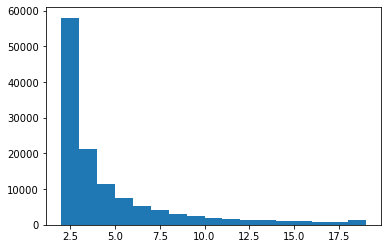

In [84]:
import matplotlib.pyplot as plt
from collections import Counter

res = Counter(list(train_df['score'].values))

plt.hist(res.values(), bins=range(2, 20))
plt.show()

In [85]:
ref_sents_df

,pmid,ref_id,pub_type,ref_pmid,sent_type,sent_id,sentence
0,11978898,R2,journal,9657795,general,0,Deliberate self-poisoning has reached epidemic...
1,11978898,R12,journal,8783813,general,8,In vitro experiments have shown that oximes ar...
2,11978898,R13,journal,8481105,general,8,In vitro experiments have shown that oximes ar...
3,11978898,R15,journal,9292288,general,8,In vitro experiments have shown that oximes ar...
4,11978898,R12,journal,8783813,general,10,"It has now become clear, however, that the deg..."
...,...,...,...,...,...,...,...
462144,31068334,R35,journal,22337868,discussion,8,In-hours staff perceived EPaCCS as a potential...
462145,31068334,R35,journal,22337868,discussion,10,None of the studies we identified explicitly e...
462146,31068334,R43,journal,11159625,discussion,31,Logical and well-intentioned policy recommenda...
462147,31068334,R44,journal,25232681,discussion,32,"However, observational studies can overestimat..."


In [86]:
paper_ref = sentences_df[sentences_df['pmid']==26194312]['sentence'].values

In [87]:
papers_to_check = list(set(ref_sents_df[ref_sents_df['pmid']==26194312]['ref_pmid'].values))

In [88]:
len(papers_to_check)

102

18. A test of several paper summarization into review one. 

In [94]:
# from .model import Summarizer as BertSum

In [96]:
model = Summarizer('bert', MODEL_SIZE)
# model.load('bert_sum')
model.froze_backbone("froze_all")
model.unfroze_head()

In [97]:
model.eval()
model, device = setup_single_gpu(model)

2021-01-01 15:56:50,428 INFO: Setup single-device settings...


In [98]:
model_ref = model

In [102]:
# Features-related evaluation is commented right now.
test_stat = {'rev_pmid':[], 'sent_num':[], 'true_rouge':[], 'diff_papers': []} #'rouge': [], 
inter = set(sentences_df['pmid'].values) & set(ref_sents_df['ref_pmid'].values)
review_papers = list(set(ref_sents_df[ref_sents_df['ref_pmid'].isin(inter)]['pmid'].values))
print(len(review_papers))
cnt = 0

for rev_id in review_papers:
    print(f"\r{rev_id} {cnt}", end="")
    cnt += 1
    paper_ref = sentences_df[sentences_df['pmid']==rev_id]['sentence'].values
    papers_to_check = list(set(ref_sents_df[ref_sents_df['pmid']==rev_id]['ref_pmid'].values))
    result = {'pmid':[], 'sentence':[], 'score':[]}
    for paper_id in papers_to_check:
        ex = test[test['pmid'] == paper_id]
        paper = ex['sentence'].values
        #features = np.nan_to_num(ex[['sent_id', 'sent_type', 'r_abs',
        #                   'num_refs', 'mean_r_fig', 'mean_r_tab', 
        #                   'min_r_fig', 'min_r_tab',
        #                   'max_r_fig', 'max_r_tab']].values.astype(float))
        total_sents = 0
        while total_sents < len(paper):
            magic = max(0, total_sents - 5)
            article_ids, article_mask, article_segment, n_setns = \
            preprocess_paper_bert(paper[magic:], MODEL_SIZE, model_ref.tokenizer)
            if n_setns <= 5:
                total_sents += 1
                continue
            old_total = total_sents
            total_sents = magic + n_setns
            input_ids = torch.tensor([article_ids]).to(device)
            input_mask = torch.tensor([article_mask]).to(device)
            input_segment = torch.tensor([article_segment]).to(device)
            #input_features = [torch.tensor(e, dtype=torch.float) for e in features[magic:total_sents]]
            #input_features = torch.stack(input_features).to(device)
            #print(input_features)
            draft_probs = model(
                        input_ids, input_mask, input_segment, #input_features,
                    )
            result['pmid'].extend([paper_id] * (total_sents - old_total))
            result['sentence'].extend(list(paper[old_total:total_sents]))
            result['score'].extend(list(draft_probs.cpu().detach().numpy())[old_total - magic:])
    res_df = pd.DataFrame(result)
    sorted_arr = sorted(list(res_df['score'].values))
    for i in range(5, 103, 5):
        if len(sorted_arr) < i:
            break
        treshold = sorted_arr[-i]
        final_text = res_df[res_df['score'] >= treshold][['pmid', 'sentence']]
        #mean_score = 0
        #num = 0
        #for sent in final_text['sentence'].values:
        #    for ref_sent in paper_ref:
        #        try:
        #            mean_score += get_rouge(sent, ref_sent)
        #            num += 1
        #        except Exception:
        #            continue
        #mean_score /= num
        real_score = get_rouge(" ".join(final_text['sentence'].values), " ".join(paper_ref))
        test_stat['rev_pmid'].append(rev_id)
        test_stat['sent_num'].append(i)
        #print(len(" ".join(final_text['sentence'].values)), len(" ".join(paper_ref)))
        
        
        #test_stat['rouge'].append(mean_score)
        test_stat['true_rouge'].append(real_score)
        test_stat['diff_papers'].append(len(set(final_text['pmid'])))
            

4399
20217853 4398

In [ ]:
print(*[len(arr) for key, arr in test_stat.items()])

In [ ]:
test_stat_df = pd.DataFrame(test_stat)

In [127]:
test_stat_df

,rev_pmid,sent_num,true_rouge,diff_papers
0,29679617,5,1.959071,1
1,29679617,10,3.232967,1
2,29679617,15,5.723856,1
3,29679617,20,7.487041,1
4,29679617,25,8.548273,1
...,...,...,...,...
37400,20217853,80,14.901693,1
37401,20217853,85,15.699245,1
37402,20217853,90,16.687216,1
37403,20217853,95,17.158034,1


In [128]:
test_stat_df = test_stat_df[test_stat_df['rev_pmid'] != 29574033]

In [129]:
test_stat_df.to_csv("~/simple_right_test_on_review.csv", index=False)

In [130]:
len(result['sentence'])

100

In [131]:
len(result['score'])

100

In [132]:
res_df = pd.DataFrame(result)

In [133]:
res_df

,pmid,sentence,score
0,18827717,"Newer, non-invasive brain imaging approaches o...",0.457018
1,18827717,These techniques permit unprecedented in vivo ...,0.457672
2,18827717,"Here, we present research aimed at generating ...",0.460970
3,18827717,With as many as 80% of all cases beginning dur...,0.457992
4,18827717,In this review we discuss the neurobiology of ...,0.460524
...,...,...,...
95,18827717,Further work is needed to validate VBM and to ...,0.442604
96,18827717,Given that the clinical phenomenology and noso...,0.455438
97,18827717,Such studies may provide further support for t...,0.455634
98,18827717,"The combined study of biological, genetic and ...",0.456030


In [134]:
treshold = sorted(list(res_df['score'].values))[-5]

In [135]:
final_text = res_df[res_df['score'] >= treshold][['pmid', 'sentence']]

In [136]:
len(set(final_text['pmid']))

1

In [137]:
" ".join(final_text['sentence'].values)

"No significant differences between patients with OCD and controls were observed on other prefrontal cortical functions, such as the delayed-response task. Woolley et al xref_bibr_R8 , using functional magnetic resonance imaging (fMRI) found that during the 'stop' task, OCD patients showed reduced activation in right orbitofrontal cortex, thalamus and basal ganglia compared to controls. These disturbances of inhibition in OCD may underlie the repetitive behavior that characterizes the illness and indicate abnormalities in orbital prefrontal ventral striatal circuits xref_bibr_R6 , xref_bibr_R7 . Furthermore, among patients, gray matter density in right lateral orbital frontal cortex correlated significantly with OCD symptom severity, but not with anxiety or depression xref_bibr_R9 . Gray matter volume of the anterior cingulate is greater in pediatric OCD patients compared to age- and sex-matched controls xref_bibr_R2 , xref_bibr_R10 ."

In [138]:
mean_score = 0
num = 0
for sent in final_text['sentence'].values:
    for ref_sent in paper_ref:
        mean_score += get_rouge(sent, ref_sent)
        num += 1
mean_score /= num

In [139]:
mean_score

9.759656406303767

In [140]:
" ".join(final_text)

'pmid sentence'

In [141]:
inter = list(set(sentences_df['pmid'].values) & set(ref_sents_df['ref_pmid'].values))

In [142]:
26194312 in inter

False

In [143]:
ref_sents_df[ref_sents_df['ref_pmid']==25559091]

,pmid,ref_id,pub_type,ref_pmid,sent_type,sent_id,sentence
327976,26194312,R118,journal,25559091,general,224,Some specific single nucleotide variants in no...


In [144]:
import pandas as pd

test_stat_df = pd.read_csv("~/simple_right_test_on_review.csv")
ft_test_stat_df = pd.read_csv("~/bertsum_test_on_review.csv")

In [151]:
test_stat_df

,rev_pmid,sent_num,true_rouge,diff_papers
0,29679617,5,1.959071,1
1,29679617,10,3.232967,1
2,29679617,15,5.723856,1
3,29679617,20,7.487041,1
4,29679617,25,8.548273,1
...,...,...,...,...
37400,20217853,80,14.901693,1
37401,20217853,85,15.699245,1
37402,20217853,90,16.687216,1
37403,20217853,95,17.158034,1


In [152]:
ft_test_stat_df

,rev_pmid,sent_num,rouge,true_rouge,diff_papers
0,29679617,5,6.553551,3.276015,2
1,29679617,10,6.846631,5.778370,2
2,29679617,15,6.616444,8.862244,2
3,29679617,20,6.364486,10.578432,2
4,29679617,25,6.609094,12.461123,2
...,...,...,...,...,...
4684,29975497,80,6.728084,31.691496,2
4685,29975497,85,6.736424,32.479650,2
4686,29975497,90,6.715395,33.044975,2
4687,29975497,95,6.746981,33.419319,2


In [145]:
df_1 = test_stat_df.assign(model = ['Основная модель']*len(test_stat_df))

In [146]:
df_2 = ft_test_stat_df.assign(model = ['BERTSUM']*len(ft_test_stat_df))

In [150]:
draw_df = pd.concat([df_1, df_2])
draw_df.head()

,rev_pmid,sent_num,true_rouge,diff_papers,model,rouge
0,29679617,5,1.959071,1,Основная модель,NaN
1,29679617,10,3.232967,1,Основная модель,NaN
2,29679617,15,5.723856,1,Основная модель,NaN
3,29679617,20,7.487041,1,Основная модель,NaN
4,29679617,25,8.548273,1,Основная модель,NaN


In [ ]:
rouge_means = []
rouge_err = []
papers_means = []
papers_err = []

for i in range(5, 103, 5):
    tmp = test_stat_df.groupby(['sent_num']).get_group(i)
    rouge_means.append(tmp['rouge'].mean())
    rouge_err.append(tmp['rouge'].std())
    papers_means.append(tmp['diff_papers'].mean())
    papers_err.append(tmp['diff_papers'].std())
    

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.errorbar(list(range(5, 103, 5)), rouge_means, yerr=rouge_err, fmt='-o')

In [ ]:
plt.errorbar(list(range(5, 103, 5)), papers_means, yerr=papers_err, fmt='-o')

In [ ]:
import seaborn as sns

In [ ]:
sns.catplot(x="sent_num", y="rouge", kind="box", hue='model', aspect=1.7, color='lightblue', data=draw_df).set_axis_labels("ЧИСЛО ПРЕДЛОЖЕНИЙ", "ROUGE, %")

In [ ]:
sns.catplot(x="sent_num", y="diff_papers", kind="box", aspect=1.5, color = 'lightblue', data=test_stat_df).set_axis_labels("ЧИСЛО ПРЕДЛОЖЕНИЙ", "ЧИСЛО СТАТЕЙ В РЕЗЮМЕ")

In [ ]:
sns.catplot(x="sent_num", y="true_rouge", kind="box", aspect=1.7, hue='model', color='lightblue', data=draw_df).set_axis_labels("ЧИСЛО ПРЕДЛОЖЕНИЙ", "ROUGE, %")